# Проект "Определение перспективного тарифа для телеком компании"

**Описание проекта**

Вы аналитик телеком компании — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей компании: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»


    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
            минута разговора: 3 рубля
            сообщение: 3 рубля
            1 Гб интернет-трафика: 200 рублей
            
            
Тариф «Ультра»


    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
            минута разговора: 1 рубль
            сообщение: 1 рубль
            1 Гб интернет-трафика: 150 рублей
            
            
Важно: Компания всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
calls = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\best_tariff\calls.csv')
internet = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\best_tariff\internet.csv')
messages = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\best_tariff\messages.csv')
tariffs = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\best_tariff\tariffs.csv')
users = pd.read_csv(r'C:\Users\Айболит\Desktop\DataFrames\projects\best_tariff\users.csv')

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [5]:
calls.loc[calls.loc[:, 'duration'] == 0].count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

в датафрейме звонков пропусков нет, что, конечно, радует, но есть нули. Откуда они взялись? Тут множество предположений, возможно это дозвоны, возможно это входящие, а возможно, что данные округлились до 0 при пересылке, заполнении ДФ. Необходимо задать вопрос ответственным людям о подсказке - как воспринимать эти нули, сравнить их с оригинальными данными. В данном случае придем к выводу, что скорее всего это округление в меньшую сторону, то есть к 0, НО! т.к. Компания всегда округляет в большую сторону, то, мы превратим нули в единицы!

Предлогаю не откладывать, а сделать это сразу замечательным методом 'where'! Сохранив наши нули в отдельный срез на всякий случай.

In [6]:
calls_zero = calls.query('duration == 0')
calls_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39613 entries, 0 to 202596
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         39613 non-null  object 
 1   call_date  39613 non-null  object 
 2   duration   39613 non-null  float64
 3   user_id    39613 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [7]:
s = calls[['duration']]
s = s.where(s != 0, 1)

calls['duration'] = s
calls.loc[calls.loc[:, 'duration'] == 0].count()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [8]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Есть абсолютно ненужный столбец -"Unnamed: 0", который следует удалить!

Удалять - не заполнять! Сделаем это!

In [10]:
internet = internet[['id','mb_used','session_date','user_id']]
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [11]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [13]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [14]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


38 человек ушли с тарифа.

Кое-что мы уже сдеали - заменили 0 на 1, убрали ненужный столбец, дублирующий индекс. Увидели, что имеются некоторые данные типа float, их нужно округлить в большую сторону, т.к. Компания ВСЕГДА округляет в большую сторону, и изменить тип данных на int, сэкономив массу дорогой памяти.

## Шаг 2. Подготовка данных.

в этом шаге сделаем ряд сводных таблиц, в которых для каждого абонента посчитаем помесячно сколько абонент расходует минут разговора, смс и интернет-трафика.

Для того, чтобы посмотреть на распределение показателей, сравнить распределение между абонентами разных тарифов.

Удобней посчитать общую прибыль с абонента помесячно и годично.

##### Приведение данных к нужным типам

In [16]:
import numpy as np

округлим значения в большую сторону и сменим тип данных с float на int:

In [17]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,1.0,1000
1,1000_1,2018-08-17,1.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499
202603,1499_216,2018-10-18,19.0,1499
202604,1499_217,2018-11-10,11.0,1499
202605,1499_218,2018-10-06,5.0,1499


In [18]:
calls['duration'] = calls['duration'].astype('int')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         202607 non-null  object
 1   call_date  202607 non-null  object
 2   duration   202607 non-null  int32 
 3   user_id    202607 non-null  int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 5.4+ MB


In [19]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
s = internet[['mb_used']]
internet['mb_used'] = s.where(s != 0, 1)
internet

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000
...,...,...,...,...
149391,1499_152,319.0,2018-10-03,1499
149392,1499_153,491.0,2018-12-14,1499
149393,1499_154,1.0,2018-10-27,1499
149394,1499_155,1247.0,2018-11-26,1499


In [20]:
internet['mb_used'] = internet['mb_used'].astype('int')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            149396 non-null  object
 1   mb_used       149396 non-null  int32 
 2   session_date  149396 non-null  object
 3   user_id       149396 non-null  int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 4.0+ MB


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB


In [22]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  int32         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 4.0+ MB


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


#### Считаю для каждого пользователя:

            1.количество сделанных звонков и израсходованных минут разговора по месяцам.

In [24]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [25]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

все пользователи принадлежат тому или иному тарифу. Они не меняли его. Это облегчает задачу, значит не нужно считать внутри одного месяца значения для 2х тарифных планов на 1 пользователя.

In [26]:
calls['month'] = calls['call_date'].dt.month
month01 = calls.query('month == 1')
min01 = month01.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min01 = min01.reset_index()
min01.columns = ['user_id', 'number_calls_01', 'duration_01']
min01.head(3)

,user_id,number_calls_01,duration_01
0,1005,15,99
1,1032,61,397
2,1045,1,9


In [27]:
def calls_min(data):
    for i in range(12):
        calls_i

In [28]:
calls['month'] = calls['call_date'].dt.month
month02 = calls.query('month == 2')
min02 = month02.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min02 = min02.reset_index()
min02.columns = ['user_id', 'number_calls_02', 'duration_02']
min02.head(3)

,user_id,number_calls_02,duration_02
0,1005,69,470
1,1006,3,42
2,1032,58,382


In [29]:
calls['month'] = calls['call_date'].dt.month
month03 = calls.query('month == 3')
min03 = month03.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min03 = min03.reset_index()
min03.columns = ['user_id', 'number_calls_03', 'duration_03']
min03.head(3)

,user_id,number_calls_03,duration_03
0,1005,77,620
1,1006,46,296
2,1009,13,110


In [30]:
calls['month'] = calls['call_date'].dt.month
month04 = calls.query('month == 4')
min04 = month04.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min04 = min04.reset_index()
min04.columns = ['user_id', 'number_calls_04', 'duration_04']
min04.head(3)

,user_id,number_calls_04,duration_04
0,1005,101,736
1,1006,47,365
2,1007,25,202


In [31]:
calls['month'] = calls['call_date'].dt.month
month05 = calls.query('month == 5')
min05 = month05.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min05 = min05.reset_index()
min05.columns = ['user_id', 'number_calls_05', 'duration_05']
min05.head(3)

,user_id,number_calls_05,duration_05
0,1000,22,164
1,1004,9,37
2,1005,73,606


In [32]:
calls['month'] = calls['call_date'].dt.month
month06 = calls.query('month == 6')
min06 = month06.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min06 = min06.reset_index()
min06.columns = ['user_id', 'number_calls_06', 'duration_06']
min06.head(3)

,user_id,number_calls_06,duration_06
0,1000,43,187
1,1002,15,118
2,1004,31,177


In [33]:
calls['month'] = calls['call_date'].dt.month
month07 = calls.query('month == 7')
min07 = month07.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min07 = min07.reset_index()
min07.columns = ['user_id', 'number_calls_07', 'duration_07']
min07.head(3)

,user_id,number_calls_07,duration_07
0,1000,47,346
1,1002,26,219
2,1004,22,137


In [34]:
calls['month'] = calls['call_date'].dt.month
month08 = calls.query('month == 8')
min08 = month08.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min08 = min08.reset_index()
min08.columns = ['user_id', 'number_calls_08', 'duration_08']
min08.head(3)

,user_id,number_calls_08,duration_08
0,1000,52,418
1,1002,42,294
2,1003,55,392


In [35]:
calls['month'] = calls['call_date'].dt.month
month09 = calls.query('month == 9')
min09 = month09.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min09 = min09.reset_index()
min09.columns = ['user_id', 'number_calls_09', 'duration_09']
min09.head(3)

,user_id,number_calls_09,duration_09
0,1000,58,478
1,1002,36,217
2,1003,134,990


In [36]:
calls['month'] = calls['call_date'].dt.month
month12 = calls.query('month == 12')
min12 = month12.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min12 = min12.reset_index()
min12.columns = ['user_id', 'number_calls_12', 'duration_12']
min12.head(3)

,user_id,number_calls_12,duration_12
0,1000,46,341
1,1001,63,430
2,1002,33,242


In [37]:
calls['month'] = calls['call_date'].dt.month
month10 = calls.query('month == 10')
min10 = month10.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min10 = min10.reset_index()
min10.columns = ['user_id', 'number_calls_10', 'duration_10']
min10.head(3)

,user_id,number_calls_10,duration_10
0,1000,57,363
1,1002,33,221
2,1003,108,866


In [38]:
calls['month'] = calls['call_date'].dt.month
month11 = calls.query('month == 11')
min11 = month11.pivot_table(index=['user_id'], values='duration', aggfunc=['count','sum'])
min11 = min11.reset_index()
min11.columns = ['user_id', 'number_calls_11', 'duration_11']
min11.head(3)

,user_id,number_calls_11,duration_11
0,1000,43,344
1,1001,59,444
2,1002,32,250


            2.количество израсходованных МЕГАбайт по месяцам.

In [39]:
internet['month'] = internet['session_date'].dt.month
month_int_1 = internet.query('month == 1')
sess1 = month_int_1.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess1 = sess1.reset_index()
sess1.columns = ['user_id', 'mb_used_month_01']
sess1.head(3)

,user_id,mb_used_month_01
0,1005,2730
1,1032,24158
2,1045,2348


In [40]:
month_int_2 = internet.query('month == 2')
sess2 = month_int_2.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess2 = sess2.reset_index()
sess2.columns = ['user_id', 'mb_used_month_02']
sess2.head(3)

,user_id,mb_used_month_02
0,1005,7396
1,1006,1399
2,1032,12516


In [41]:
month_int_3 = internet.query('month == 3')
sess3 = month_int_3.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess3 = sess3.reset_index()
sess3.columns = ['user_id', 'mb_used_month_03']
sess3.head(3)

,user_id,mb_used_month_03
0,1005,11120
1,1006,17318
2,1009,7361


In [42]:
month_int_4 = internet.query('month == 4')
sess4 = month_int_4.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess4 = sess4.reset_index()
sess4.columns = ['user_id', 'mb_used_month_04']
sess4.head(3)

,user_id,mb_used_month_04
0,1005,9371
1,1006,13963
2,1007,8034


In [43]:
month_int_5 = internet.query('month == 5')
sess5 = month_int_5.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess5 = sess5.reset_index()
sess5.columns = ['user_id', 'mb_used_month_05']
sess5.head(3)

,user_id,mb_used_month_05
0,1000,2257
1,1004,13415
2,1005,7882


In [44]:
month_int_6 = internet.query('month == 6')
sess6 = month_int_6.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess6 = sess6.reset_index()
sess6.columns = ['user_id', 'mb_used_month_06']
sess6.head(3)

,user_id,mb_used_month_06
0,1000,23262
1,1002,10878
2,1004,17621


In [45]:
month_int_7 = internet.query('month == 7')
sess7 = month_int_7.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess7 = sess7.reset_index()
sess7.columns = ['user_id', 'mb_used_month_07']
sess7.head(3)

,user_id,mb_used_month_07
0,1000,14017
1,1002,17615
2,1004,22246


In [46]:
month_int_8 = internet.query('month == 8')
sess8 = month_int_8.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess8 = sess8.reset_index()
sess8.columns = ['user_id', 'mb_used_month_08']
sess8.head(3)

,user_id,mb_used_month_08
0,1000,14072
1,1002,20357
2,1003,8572


In [47]:
month_int_9 = internet.query('month == 9')
sess9 = month_int_9.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess9 = sess9.reset_index()
sess9.columns = ['user_id', 'mb_used_month_09']
sess9.head(3)

,user_id,mb_used_month_09
0,1000,14583
1,1002,16724
2,1003,12479


In [48]:
month_int_10 = internet.query('month == 10')
sess10 = month_int_10.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess10 = sess10.reset_index()
sess10.columns = ['user_id', 'mb_used_month_10']
sess10.head(3)

,user_id,mb_used_month_10
0,1000,14717
1,1002,13913
2,1003,14779


In [49]:
month_int_11 = internet.query('month == 11')
sess11 = month_int_11.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess11 = sess11.reset_index()
sess11.columns = ['user_id', 'mb_used_month_11']
sess11.head(3)

,user_id,mb_used_month_11
0,1000,14769
1,1001,18460
2,1002,18621


In [50]:
month_int_12 = internet.query('month == 12')
sess12 = month_int_12.pivot_table(index=['user_id'], values='mb_used', aggfunc='sum')
sess12 = sess12.reset_index()
sess12.columns = ['user_id', 'mb_used_month_12']
sess12.head(3)

,user_id,mb_used_month_12
0,1000,9829
1,1001,14059
2,1002,18147


            3. количество СМС по месяцам

In [51]:
messages['month'] = messages['message_date'].dt.month
month_mess_1 = messages.query('month == 1')
mess1 = month_mess_1.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess1 = mess1.reset_index()
mess1.columns = ['user_id', 'count_message_01']
mess1.head(3)


,user_id,count_message_01
0,1005,7
1,1032,38
2,1045,5


In [52]:
month_mess_2 = messages.query('month == 2')
mess2 = month_mess_2.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess2 = mess2.reset_index()
mess2.columns = ['user_id', 'count_message_02']
mess2.head(3)

,user_id,count_message_02
0,1005,38
1,1032,36
2,1045,49


In [53]:
month_mess_3 = messages.query('month == 3')
mess3 = month_mess_3.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess3 = mess3.reset_index()
mess3.columns = ['user_id', 'count_message_03']
mess3.head(3)

,user_id,count_message_03
0,1005,56
1,1009,2
2,1011,4


In [54]:
month_mess_4 = messages.query('month == 4')
mess4 = month_mess_4.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess4 = mess4.reset_index()
mess4.columns = ['user_id', 'count_message_04']
mess4.head(3)

,user_id,count_message_04
0,1005,41
1,1007,11
2,1009,14


In [55]:
month_mess_5 = messages.query('month == 5')
mess5 = month_mess_5.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess5 = mess5.reset_index()
mess5.columns = ['user_id', 'count_message_05']
mess5.head(3)

,user_id,count_message_05
0,1000,22
1,1004,95
2,1005,42


In [56]:
month_mess_6 = messages.query('month == 6')
mess6 = month_mess_6.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess6 = mess6.reset_index()
mess6.columns = ['user_id', 'count_message_06']
mess6.head(3)

,user_id,count_message_06
0,1000,60
1,1002,4
2,1004,134


In [57]:
month_mess_7 = messages.query('month == 7')
mess7 = month_mess_7.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess7 = mess7.reset_index()
mess7.columns = ['user_id', 'count_message_07']
mess7.head(3)

,user_id,count_message_07
0,1000,75
1,1002,11
2,1004,181


In [58]:
month_mess_8 = messages.query('month == 8')
mess8 = month_mess_8.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess8 = mess8.reset_index()
mess8.columns = ['user_id', 'count_message_08']
mess8.head(3)

,user_id,count_message_08
0,1000,81
1,1002,13
2,1003,37


In [59]:
month_mess_9 = messages.query('month == 9')
mess9 = month_mess_9.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess9 = mess9.reset_index()
mess9.columns = ['user_id', 'count_message_09']
mess9.head(3)

,user_id,count_message_09
0,1000,57
1,1002,4
2,1003,91


In [60]:
month_mess_10 = messages.query('month == 10')
mess10 = month_mess_10.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess10 = mess10.reset_index()
mess10.columns = ['user_id', 'count_message_10']
mess10.head(3)

,user_id,count_message_10
0,1000,73
1,1002,10
2,1003,83


In [61]:
month_mess_11 = messages.query('month == 11')
mess11 = month_mess_11.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess11 = mess11.reset_index()
mess11.columns = ['user_id', 'count_message_11']
mess11.head(3)

,user_id,count_message_11
0,1000,58
1,1002,16
2,1003,94


In [62]:
month_mess_12 = messages.query('month == 12')
mess12 = month_mess_12.pivot_table(index=['user_id'], values='id', aggfunc='count')
mess12 = mess12.reset_index()
mess12.columns = ['user_id', 'count_message_12']
mess12.head(3)

,user_id,count_message_12
0,1000,70
1,1002,12
2,1003,75


Посчитал количество звонков и длительность, израсходованные мегабайты и кол-вo смс за месяц. Далее склеиваю в общую МЕГАтаблицу и считаю выручку.

In [63]:
general01 = users[['user_id','tariff']]
general01 = general01.join(min01.set_index('user_id'), on='user_id')
general01 = general01.join(sess1.set_index('user_id'), on='user_id')
general01 = general01.join(mess1.set_index('user_id'), on='user_id')
general01 = general01.fillna(0)
general01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           500 non-null    int64  
 1   tariff            500 non-null    object 
 2   number_calls_01   500 non-null    float64
 3   duration_01       500 non-null    float64
 4   mb_used_month_01  500 non-null    float64
 5   count_message_01  500 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 23.6+ KB


Ниже - функция, которая посчитает для каждого абонента его годовую прибыль компании с учетом округления вверх.

In [64]:
def profit(row):
    if row['tariff'] == "smart":
        count_min = row[3] - 500
        if count_min > 0:
            profit_min = count_min * 3
        else:
            profit_min = 0
        count_mess = row[5] - 50
        if count_mess > 0:
            profit_mess = count_mess * 3
        else:
            profit_mess = 0
        count_mb = row[4] - 15000
        if count_mb > 0:
            profit_mb = np.ceil(count_mb/1000) * 200
        else:
            profit_mb = 0
        if (row[3] != 0) & (row[4] != 0):
            profit_total = 550+profit_min+profit_mess+profit_mb
        else:
            profit_total = 0
    else:
        count_min = row[3] - 3000
        if count_min > 0:
            profit_min = count_min
        else:
            profit_min = 0
        count_mess = row[5] - 1000
        if count_mess > 0:
            profit_mess = count_mess
        else:
            profit_mess = 0
        count_mb = row[4] - 30000
        if count_mb > 0:
            profit_mb = np.ceil(count_mb/1000) * 150
        else:
            profit_mb = 0
        if (row[3] != 0) & (row[4] != 0):
            profit_total = profit_total = 1950+profit_min+profit_mess+profit_mb
        else:
            profit_total = 0
    return(profit_total)

In [65]:
general01['profit_01'] = general01.apply(profit,axis=1)
general01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           500 non-null    int64  
 1   tariff            500 non-null    object 
 2   number_calls_01   500 non-null    float64
 3   duration_01       500 non-null    float64
 4   mb_used_month_01  500 non-null    float64
 5   count_message_01  500 non-null    float64
 6   profit_01         500 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 27.5+ KB


In [66]:
general02 = users[['user_id','tariff']]
general02 = general02.join(min02.set_index('user_id'), on='user_id')
general02 = general02.join(sess2.set_index('user_id'), on='user_id')
general02 = general02.join(mess2.set_index('user_id'), on='user_id')
general02 = general02.fillna(0)
general02.head(2)

,user_id,tariff,number_calls_02,duration_02,mb_used_month_02,count_message_02
0,1000,ultra,0.0,0.0,0.0,0.0
1,1001,smart,0.0,0.0,0.0,0.0


In [67]:
general02['profit_02'] = general02.apply(profit,axis=1)
general02.head(2)

,user_id,tariff,number_calls_02,duration_02,mb_used_month_02,count_message_02,profit_02
0,1000,ultra,0.0,0.0,0.0,0.0,0.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0


In [68]:
general03 = users[['user_id','tariff']]
general03 = general03.join(min03.set_index('user_id'), on='user_id')
general03 = general03.join(sess3.set_index('user_id'), on='user_id')
general03 = general03.join(mess3.set_index('user_id'), on='user_id')
general03 = general03.fillna(0)
general03.head(2)

,user_id,tariff,number_calls_03,duration_03,mb_used_month_03,count_message_03
0,1000,ultra,0.0,0.0,0.0,0.0
1,1001,smart,0.0,0.0,0.0,0.0


In [69]:
general03['profit_03'] = general03.apply(profit,axis=1)
general03.head(2)

,user_id,tariff,number_calls_03,duration_03,mb_used_month_03,count_message_03,profit_03
0,1000,ultra,0.0,0.0,0.0,0.0,0.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0


In [70]:
general04 = users[['user_id','tariff']]
general04 = general04.join(min04.set_index('user_id'), on='user_id')
general04 = general04.join(sess4.set_index('user_id'), on='user_id')
general04 = general04.join(mess4.set_index('user_id'), on='user_id')
general04 = general04.fillna(0)
general04.head(2)

,user_id,tariff,number_calls_04,duration_04,mb_used_month_04,count_message_04
0,1000,ultra,0.0,0.0,0.0,0.0
1,1001,smart,0.0,0.0,0.0,0.0


In [71]:
general04['profit_04'] = general04.apply(profit,axis=1)
general04.head(2)

,user_id,tariff,number_calls_04,duration_04,mb_used_month_04,count_message_04,profit_04
0,1000,ultra,0.0,0.0,0.0,0.0,0.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0


In [72]:
general05 = users[['user_id','tariff']]
general05 = general05.join(min05.set_index('user_id'), on='user_id')
general05 = general05.join(sess5.set_index('user_id'), on='user_id')
general05 = general05.join(mess5.set_index('user_id'), on='user_id')
general05 = general05.fillna(0)
general05.head(2)

,user_id,tariff,number_calls_05,duration_05,mb_used_month_05,count_message_05
0,1000,ultra,22.0,164.0,2257.0,22.0
1,1001,smart,0.0,0.0,0.0,0.0


In [73]:
general05['profit_05'] = general05.apply(profit,axis=1)
general05.head(2)

,user_id,tariff,number_calls_05,duration_05,mb_used_month_05,count_message_05,profit_05
0,1000,ultra,22.0,164.0,2257.0,22.0,1950.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0


In [74]:
general06 = users[['user_id','tariff']]
general06 = general06.join(min06.set_index('user_id'), on='user_id')
general06 = general06.join(sess6.set_index('user_id'), on='user_id')
general06 = general06.join(mess6.set_index('user_id'), on='user_id')
general06 = general06.fillna(0)
general06.head(2)

,user_id,tariff,number_calls_06,duration_06,mb_used_month_06,count_message_06
0,1000,ultra,43.0,187.0,23262.0,60.0
1,1001,smart,0.0,0.0,0.0,0.0


In [75]:
general06['profit_06'] = general06.apply(profit,axis=1)
general06.head(2)

,user_id,tariff,number_calls_06,duration_06,mb_used_month_06,count_message_06,profit_06
0,1000,ultra,43.0,187.0,23262.0,60.0,1950.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0


In [76]:
general07 = users[['user_id','tariff']]
general07 = general07.join(min07.set_index('user_id'), on='user_id')
general07 = general07.join(sess7.set_index('user_id'), on='user_id')
general07 = general07.join(mess7.set_index('user_id'), on='user_id')
general07 = general07.fillna(0)
general07.head(2)

,user_id,tariff,number_calls_07,duration_07,mb_used_month_07,count_message_07
0,1000,ultra,47.0,346.0,14017.0,75.0
1,1001,smart,0.0,0.0,0.0,0.0


In [77]:
general07['profit_07'] = general07.apply(profit,axis=1)
general07.head(2)

,user_id,tariff,number_calls_07,duration_07,mb_used_month_07,count_message_07,profit_07
0,1000,ultra,47.0,346.0,14017.0,75.0,1950.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0


In [78]:
general08 = users[['user_id','tariff']]
general08 = general08.join(min08.set_index('user_id'), on='user_id')
general08 = general08.join(sess8.set_index('user_id'), on='user_id')
general08 = general08.join(mess8.set_index('user_id'), on='user_id')
general08 = general08.fillna(0)
general08.head(2)

,user_id,tariff,number_calls_08,duration_08,mb_used_month_08,count_message_08
0,1000,ultra,52.0,418.0,14072.0,81.0
1,1001,smart,0.0,0.0,0.0,0.0


In [79]:
general08['profit_08'] = general08.apply(profit,axis=1)
general08.head(2)

,user_id,tariff,number_calls_08,duration_08,mb_used_month_08,count_message_08,profit_08
0,1000,ultra,52.0,418.0,14072.0,81.0,1950.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0


In [80]:
general09 = users[['user_id','tariff']]
general09 = general09.join(min09.set_index('user_id'), on='user_id')
general09 = general09.join(sess9.set_index('user_id'), on='user_id')
general09 = general09.join(mess9.set_index('user_id'), on='user_id')
general09 = general09.fillna(0)
general09.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           500 non-null    int64  
 1   tariff            500 non-null    object 
 2   number_calls_09   500 non-null    float64
 3   duration_09       500 non-null    float64
 4   mb_used_month_09  500 non-null    float64
 5   count_message_09  500 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 23.6+ KB


In [81]:
general09['profit_09'] = general09.apply(profit,axis=1)
general09.head(2)

,user_id,tariff,number_calls_09,duration_09,mb_used_month_09,count_message_09,profit_09
0,1000,ultra,58.0,478.0,14583.0,57.0,1950.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0


In [82]:
general10 = users[['user_id','tariff']]
general10 = general10.join(min10.set_index('user_id'), on='user_id')
general10 = general10.join(sess10.set_index('user_id'), on='user_id')
general10 = general10.join(mess10.set_index('user_id'), on='user_id')
general10 = general10.fillna(0)
general10.head(2)

,user_id,tariff,number_calls_10,duration_10,mb_used_month_10,count_message_10
0,1000,ultra,57.0,363.0,14717.0,73.0
1,1001,smart,0.0,0.0,0.0,0.0


In [83]:
general10['profit_10'] = general10.apply(profit,axis=1)
general10.head(2)

,user_id,tariff,number_calls_10,duration_10,mb_used_month_10,count_message_10,profit_10
0,1000,ultra,57.0,363.0,14717.0,73.0,1950.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0


In [84]:
general11 = users[['user_id','tariff']]
general11 = general11.join(min11.set_index('user_id'), on='user_id')
general11 = general11.join(sess11.set_index('user_id'), on='user_id')
general11 = general11.join(mess11.set_index('user_id'), on='user_id')
general11 = general11.fillna(0)
general11.head(2)

,user_id,tariff,number_calls_11,duration_11,mb_used_month_11,count_message_11
0,1000,ultra,43.0,344.0,14769.0,58.0
1,1001,smart,59.0,444.0,18460.0,0.0


In [85]:
general11['profit_11'] = general11.apply(profit,axis=1)
general11.head(2)

,user_id,tariff,number_calls_11,duration_11,mb_used_month_11,count_message_11,profit_11
0,1000,ultra,43.0,344.0,14769.0,58.0,1950.0
1,1001,smart,59.0,444.0,18460.0,0.0,1350.0


In [86]:
general12 = users[['user_id','tariff']]
general12 = general12.join(min12.set_index('user_id'), on='user_id')
general12 = general12.join(sess12.set_index('user_id'), on='user_id')
general12 = general12.join(mess12.set_index('user_id'), on='user_id')
general12 = general12.fillna(0)
general12.head(2)

,user_id,tariff,number_calls_12,duration_12,mb_used_month_12,count_message_12
0,1000,ultra,46.0,341.0,9829.0,70.0
1,1001,smart,63.0,430.0,14059.0,0.0


In [87]:
general12['profit_12'] = general12.apply(profit,axis=1)
general12.head(2)

,user_id,tariff,number_calls_12,duration_12,mb_used_month_12,count_message_12,profit_12
0,1000,ultra,46.0,341.0,9829.0,70.0,1950.0
1,1001,smart,63.0,430.0,14059.0,0.0,550.0


In [88]:
general = general01.merge(general02, on='user_id', how='right')
general = general.drop(['tariff_y'],axis=1)
general = general.merge(general03, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.merge(general04, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.merge(general05, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.merge(general06, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.merge(general07, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.merge(general08, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.merge(general09, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.merge(general10, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.merge(general11, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.merge(general12, on='user_id', how='right')
general = general.drop(['tariff'],axis=1)
general = general.rename(columns={"tariff_x" : "tariff"})

general.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           500 non-null    int64  
 1   tariff            500 non-null    object 
 2   number_calls_01   500 non-null    float64
 3   duration_01       500 non-null    float64
 4   mb_used_month_01  500 non-null    float64
 5   count_message_01  500 non-null    float64
 6   profit_01         500 non-null    float64
 7   number_calls_02   500 non-null    float64
 8   duration_02       500 non-null    float64
 9   mb_used_month_02  500 non-null    float64
 10  count_message_02  500 non-null    float64
 11  profit_02         500 non-null    float64
 12  number_calls_03   500 non-null    float64
 13  duration_03       500 non-null    float64
 14  mb_used_month_03  500 non-null    float64
 15  count_message_03  500 non-null    float64
 16  profit_03         500 non-null    float64
 1

In [89]:
general['total_profit'] = general['profit_01'] + general['profit_02'] + general['profit_03'] + general['profit_04'] + general['profit_05'] + general['profit_06'] + general['profit_07'] + general['profit_08'] + general['profit_09'] + general['profit_10'] + general['profit_11'] + general['profit_12']


Посчитал:

    количество сделанных звонков и израсходованных минут разговора по месяцам;

    количество отправленных сообщений по месяцам;

    объем израсходованного интернет-трафика по месяцам;

    помесячную выручку с каждого пользователя.

    И приготовил данные к дальнейшей работе
    
Далее в шаге 3 посмотрим на распределение, закономерности, возможные выбросы, расчитаем срение и медиану.

### Шаг 3. Анализируем данные

делаю срезы, разделяю общую таблицу на две, исходя из тарифа.

Нужно для сравнения абонентов разных тарифов.

In [90]:
general_smart = general.query('tariff == "smart"')
general_ultra = general.query('tariff == "ultra"')

Далее смотрим как ведёт себя метрика - "длительность разговоров" абонентов обоих тарифов. Посмотрим на распределение, посчитаем средние и медианы, дисперсию и стандартное отклонение. 


In [91]:
duration_smart = general_smart[['duration_01','duration_02','duration_03','duration_04','duration_05','duration_06','duration_07','duration_08','duration_09','duration_10','duration_11','duration_12']]
duration_ultra = general_ultra[['duration_01','duration_02','duration_03','duration_04','duration_05','duration_06','duration_07','duration_08','duration_09','duration_10','duration_11','duration_12']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC50946FC8>,
      dtype=object)

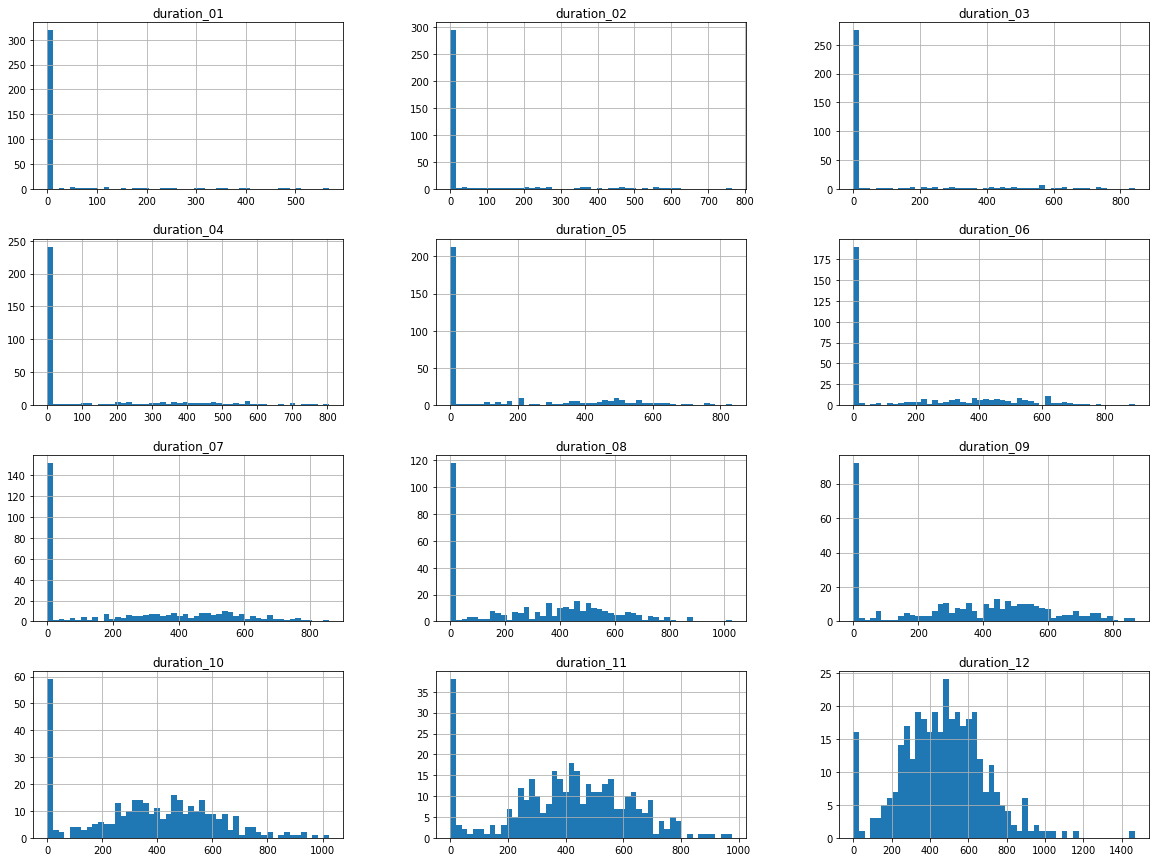

In [92]:
duration_smart.hist(bins=50,figsize=(20, 15))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC558006C8>,
      dtype=object)

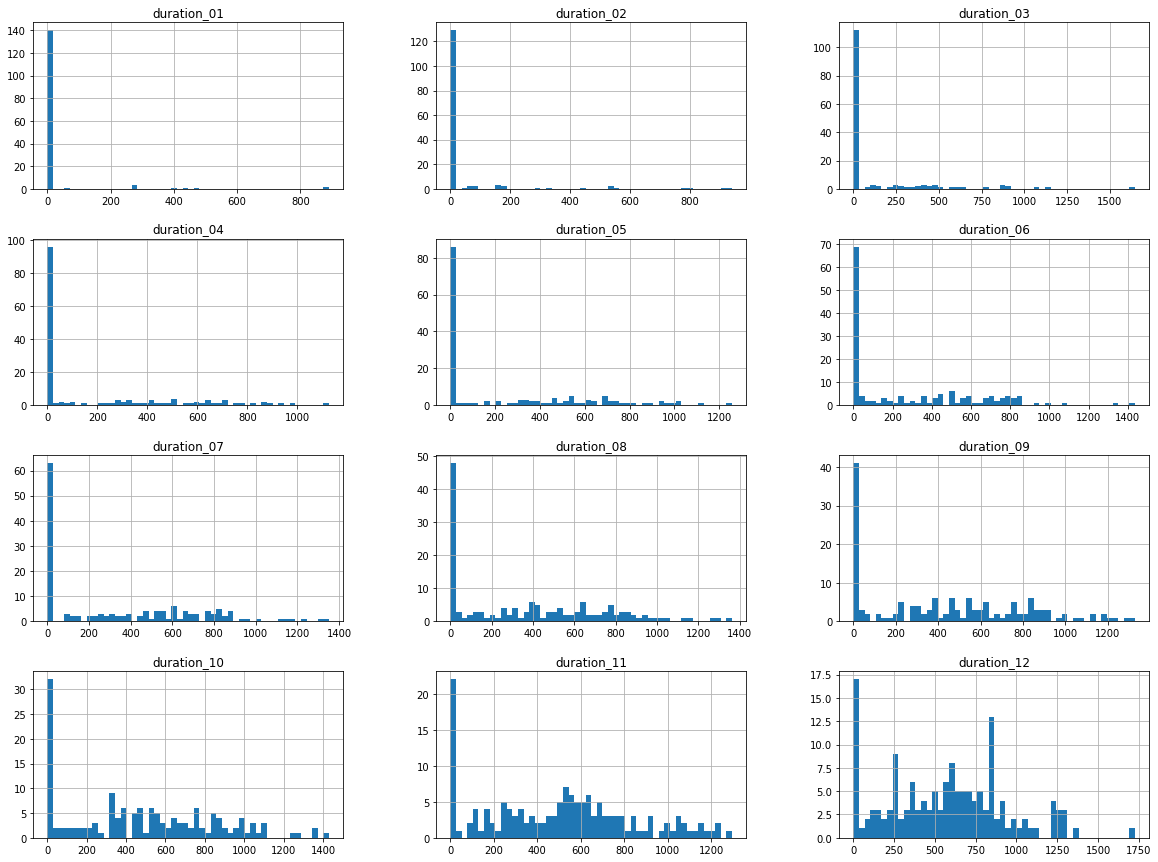

In [93]:
duration_ultra.hist(bins=50,figsize=(20, 15))

Посмотрел по месяцам. Большинство абонентов присоединились в течение года. Поэтому предлогаю склеить все "ненулевые" значения в один датафрейм и посмотреть на полное распределение.

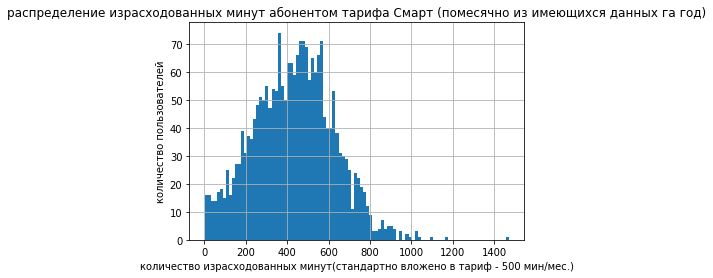

In [94]:
total_duration_smart = pd.concat([general_smart['duration_12'],general_smart['duration_01'],general_smart['duration_02'],general_smart['duration_03'],general_smart['duration_04'],general_smart['duration_05'],general_smart['duration_06'],general_smart['duration_07'],general_smart['duration_08'],general_smart['duration_09'],general_smart['duration_10'],general_smart['duration_11']])
total_duration_smart_without_0 = total_duration_smart.loc[~(total_duration_smart==0)]
frame = {'duration_smart' : total_duration_smart_without_0}
total_duration_smart_df = pd.DataFrame(frame)
total_duration_smart_df.hist(bins=100)
plt.title("распределение израсходованных минут абонентов тарифа Смарт (помесячно из имеющихся данных за год)"); 
plt.xlabel("количество израсходованных минут(стандартно вложено в тариф - 500 мин/мес.)")
plt.ylabel("количество пользователей")
plt.show()

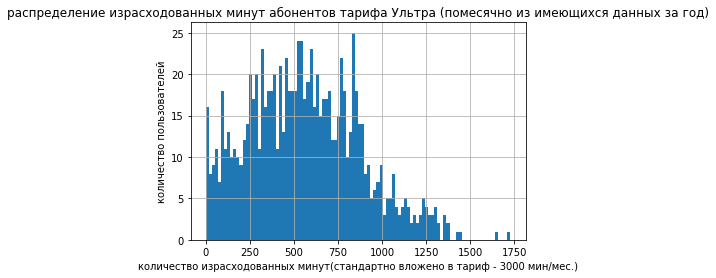

In [227]:
total_duration_ultra = pd.concat([general_ultra['duration_12'],general_ultra['duration_01'],general_ultra['duration_02'],general_ultra['duration_03'],general_ultra['duration_04'],general_ultra['duration_05'],general_ultra['duration_06'],general_ultra['duration_07'],general_ultra['duration_08'],general_ultra['duration_09'],general_ultra['duration_10'],general_ultra['duration_11']])
total_duration_ultra_without_0 = total_duration_ultra.loc[~(total_duration_ultra==0)]
frame = {'duration_ultra' : total_duration_ultra_without_0}
total_duration_ultra_df = pd.DataFrame(frame)
total_duration_ultra_df.hist(bins=100)
plt.title("распределение израсходованных минут абонентов тарифа Ультра (помесячно из имеющихся данных за год)"); 
plt.xlabel("количество израсходованных минут(стандартно вложено в тариф - 3000 мин/мес.)")
plt.ylabel("количество пользователей")
plt.show()

In [96]:
total_duration_smart_without_0.describe()

count    2223.000000
mean      430.609987
std       193.850373
min         1.000000
25%       292.000000
50%       435.000000
75%       561.000000
max      1471.000000
dtype: float64

In [97]:
more_500_min_smart = total_duration_smart_df.query('duration_smart > 500')

In [98]:
len(more_500_min_smart)/len(total_duration_smart_df)

0.36482231219073324

36% абонентам тарифа Смарт не хватило пакета бесплатных минут. В то время как  из абонентов тарифа Ультра только единицы едва смогли израсходовать половину бесплатных минут.

In [99]:
total_duration_ultra_without_0.describe()

count     951.000000
mean      560.113565
std       314.742170
min         1.000000
25%       318.000000
50%       544.000000
75%       776.500000
max      1727.000000
dtype: float64

In [100]:
total_duration_smart_without_0.median()

435.0

In [101]:
total_duration_smart_without_0.mean()

430.60998650472334

In [102]:
total_duration_ultra_without_0.median()

544.0

In [103]:
total_duration_ultra_without_0.mean()

560.1135646687698

мы посмотрели на распределение общей длительности по месяцам и за год среди пользователей и узнали сколько минут они в среднем говорят в месяц.

абоненты тарифа Смарт - около 430 мин\мес, абоненты тарифа Ультра около 550 мин\мес. С учетом того, что у абонентов Ультра количество минут - 3000\мес, в 6 раз больше, чем у Смарта, количество израсходованных минут примерно совпадает. Вероятно, что они бы совпадали до десятка минут, если бы у абонентом Смарта не стояло ограничения. Но в общем можно сказать, что острой нехватки минут нет, т.к. 75% абонентом Смарта укладываются в диапозон до 570 минут.

а теперь давайте посмотрим сколько минут составляет средний звонок обоих тарифов.

In [104]:
users_tariff = users[['user_id', 'tariff']]

In [105]:
calls_with_tariff = users_tariff.join(calls.set_index('user_id'), on = 'user_id')

In [106]:
calls_smart = calls_with_tariff.query('tariff == "smart"')
calls_ultra = calls_with_tariff.query('tariff == "ultra"')

12ый месяц вершится Новым Годом, когда все начинают звонить и поздравлять друг друга, поэтому есть предположение, что в декабре длительность "среднего" звонка будет выше, чем за первые 11 месяцев, а если ещё исключить и январь......

Вперёд, экспериментируем, смотрим! Но для отчёта будем использовать годичные выводы, т.к. каждый год люди празднуют эти праздники. Предлогаю посмотреть на общее распределение и распределение без учёта декабря, т.к. в 12 месяце близится Новый Год и возможно количество звонков и их длительность увеличится.

In [107]:
calls_smart_without_12 = calls_smart.query('month < 12')
calls_smart_without_01 = calls_smart.query('month > 1')
calls_ultra_without_12 = calls_ultra.query('month < 12')
calls_ultra_without_01 = calls_ultra.query('month > 1')

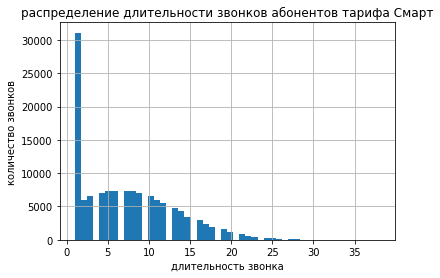

In [232]:
calls_smart['duration'].hist(bins=50)
plt.title("распределение длительности звонков абонентов тарифа Смарт"); 
plt.xlabel("длительность звонка")
plt.ylabel("количество звонков")
plt.show()

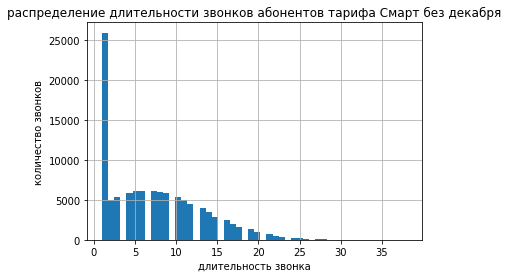

In [231]:
calls_smart_without_12['duration'].hist(bins=50)
plt.title("распределение длительности звонков абонентов тарифа Смарт без декабря"); 
plt.xlabel("длительность звонка")
plt.ylabel("количество звонков")
plt.show()

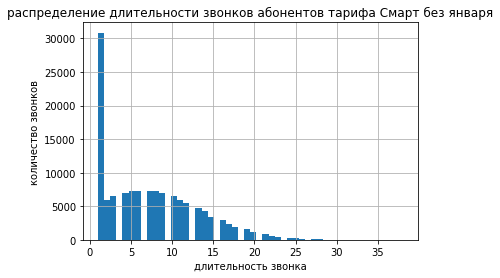

In [237]:
calls_smart_without_01['duration'].hist(bins=50)
plt.title("распределение длительности звонков абонентов тарифа Смарт без января"); 
plt.xlabel("длительность звонка")
plt.ylabel("количество звонков")
plt.show()

In [111]:
calls_smart['duration'].describe()

count    130315.000000
mean          7.345632
std           5.731598
min           1.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

In [112]:
calls_smart_without_12['duration'].describe()

count    107909.000000
mean          7.336163
std           5.733898
min           1.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

In [113]:
calls_smart_without_01['duration'].describe()

count    129374.000000
mean          7.343964
std           5.730628
min           1.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

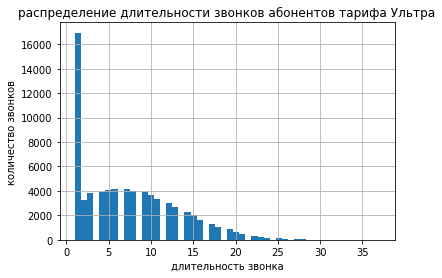

In [235]:
calls_ultra['duration'].hist(bins=50)
plt.title("распределение длительности звонков абонентов тарифа Ультра"); 
plt.xlabel("длительность звонка")
plt.ylabel("количество звонков")
plt.show()

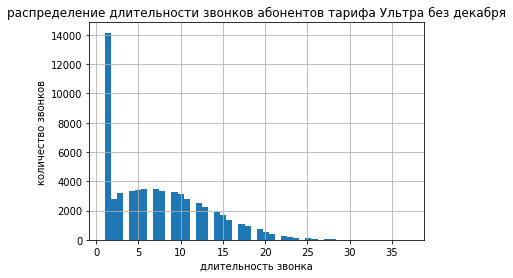

In [236]:
calls_ultra_without_12['duration'].hist(bins=50)
plt.title("распределение длительности звонков абонентов тарифа Ультра без декабря"); 
plt.xlabel("длительность звонка")
plt.ylabel("количество звонков")
plt.show()

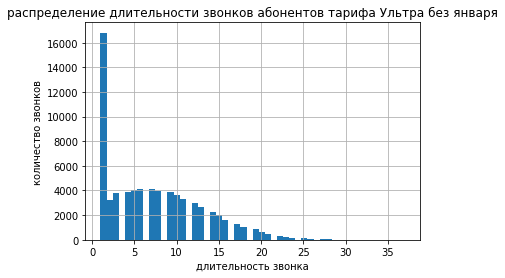

In [238]:
calls_ultra_without_01['duration'].hist(bins=50)
plt.title("распределение длительности звонков абонентов тарифа Ультра без января"); 
plt.xlabel("длительность звонка")
plt.ylabel("количество звонков")
plt.show()

In [117]:
calls_ultra['duration'].describe()

count    72292.000000
mean         7.368284
std          5.736181
min          1.000000
25%          2.000000
50%          7.000000
75%         11.000000
max         37.000000
Name: duration, dtype: float64

In [118]:
calls_ultra_without_12['duration'].describe()

count    60711.000000
mean         7.379206
std          5.737048
min          1.000000
25%          2.000000
50%          7.000000
75%         11.000000
max         37.000000
Name: duration, dtype: float64

In [119]:
calls_ultra_without_01['duration'].describe()

count    71757.000000
mean         7.367922
std          5.735088
min          1.000000
25%          2.000000
50%          7.000000
75%         11.000000
max         37.000000
Name: duration, dtype: float64

На длительность совершаемых звонков абонентами канун НГ и рожденственская неделя никак не влияют. Причём! Интересное наблюдение, среднее и медиана длительности разговором, а также распределение - абсолютно одинаковы! Есть предположение, что на родных и друзей - люди тратят мегабайты, разговаривая в приложении Воцап и ему подобным, но не обязательно расход интернет трафика возрастёт, т.к. работа этих приложений может не тарифицироваться, может люди используют wi-fi подключение, да и расход трафика на такие звонки крайне мал, и врядли будет заметен.

Вернёмся к этим наблюдениям, когда изучим количество звонков. Хоть распределение и одинаково, и средние равны, тем не менее среднее и медиана месячной длительности разговоров абонентов Ultra выше на 100 минут, чем у абонентов тарифа Smart.

In [120]:
variance_smart = np.var(total_duration_smart_without_0,ddof=1)
variance_smart

37577.96708294317

In [121]:
variance_ultra = np.var(total_duration_ultra_without_0,ddof=1)
variance_ultra

99062.63340527966

In [122]:
standart_deviation_smart = np.std(total_duration_smart_without_0,ddof=1)
standart_deviation_smart

193.85037292443667

In [123]:
standart_deviation_ultra = np.std(total_duration_ultra_without_0,ddof=1)
standart_deviation_ultra

314.74216972830266

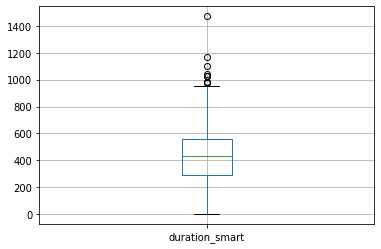

In [124]:
total_duration_smart_df.boxplot()

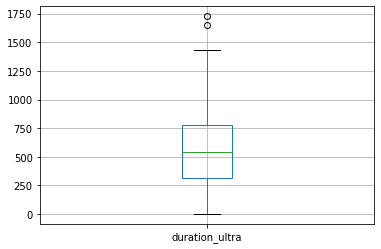

In [125]:
total_duration_ultra_df.boxplot()

Распределение Пуассона. 

#### далее смотрим как ведёт себя метрика "количество звонков"

In [126]:
count_calls_smart = general_smart[['number_calls_01','number_calls_02','number_calls_03','number_calls_04','number_calls_05','number_calls_06','number_calls_07','number_calls_08','number_calls_09','number_calls_10','number_calls_11','number_calls_12']]
count_calls_ultra = general_ultra[['number_calls_01','number_calls_02','number_calls_03','number_calls_04','number_calls_05','number_calls_06','number_calls_07','number_calls_08','number_calls_09','number_calls_10','number_calls_11','number_calls_12']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC59962688>,
      dtype=object)

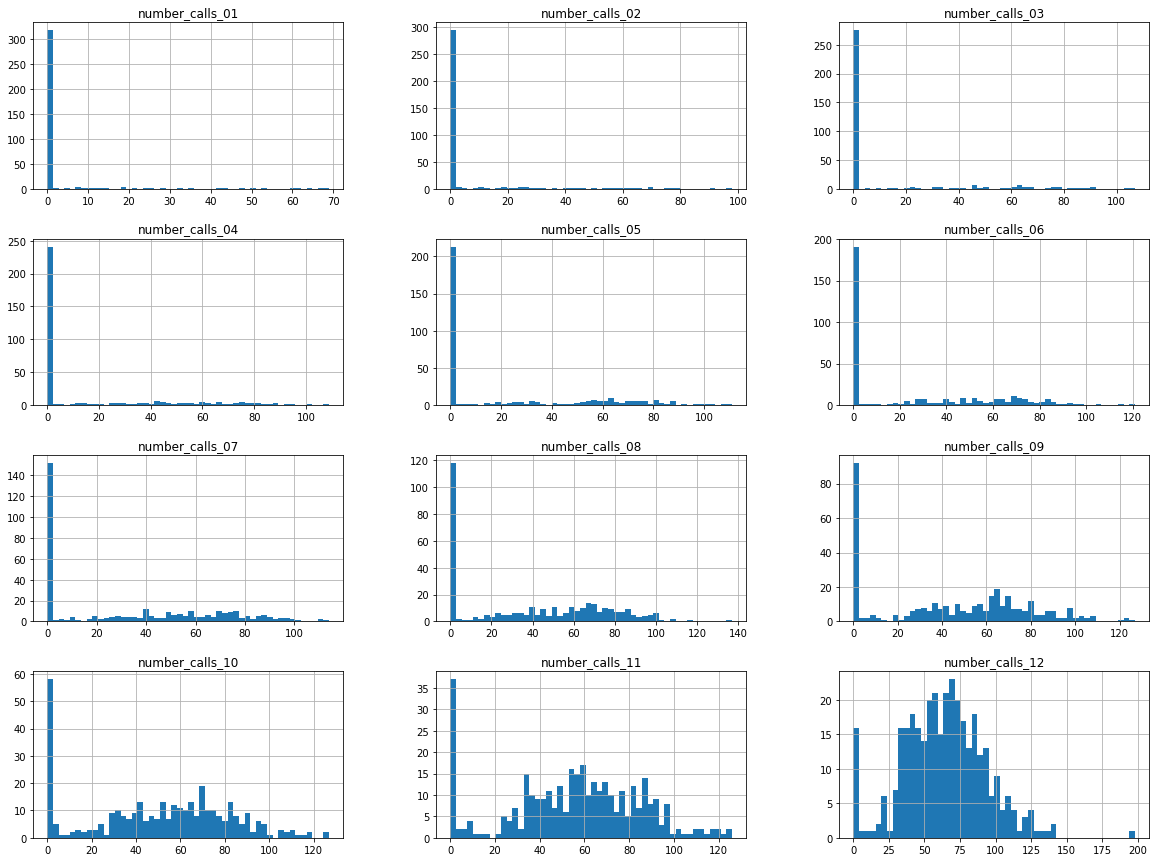

In [127]:
count_calls_smart.hist(bins=50,figsize=(20, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC5BAE6548>,
      dtype=object)

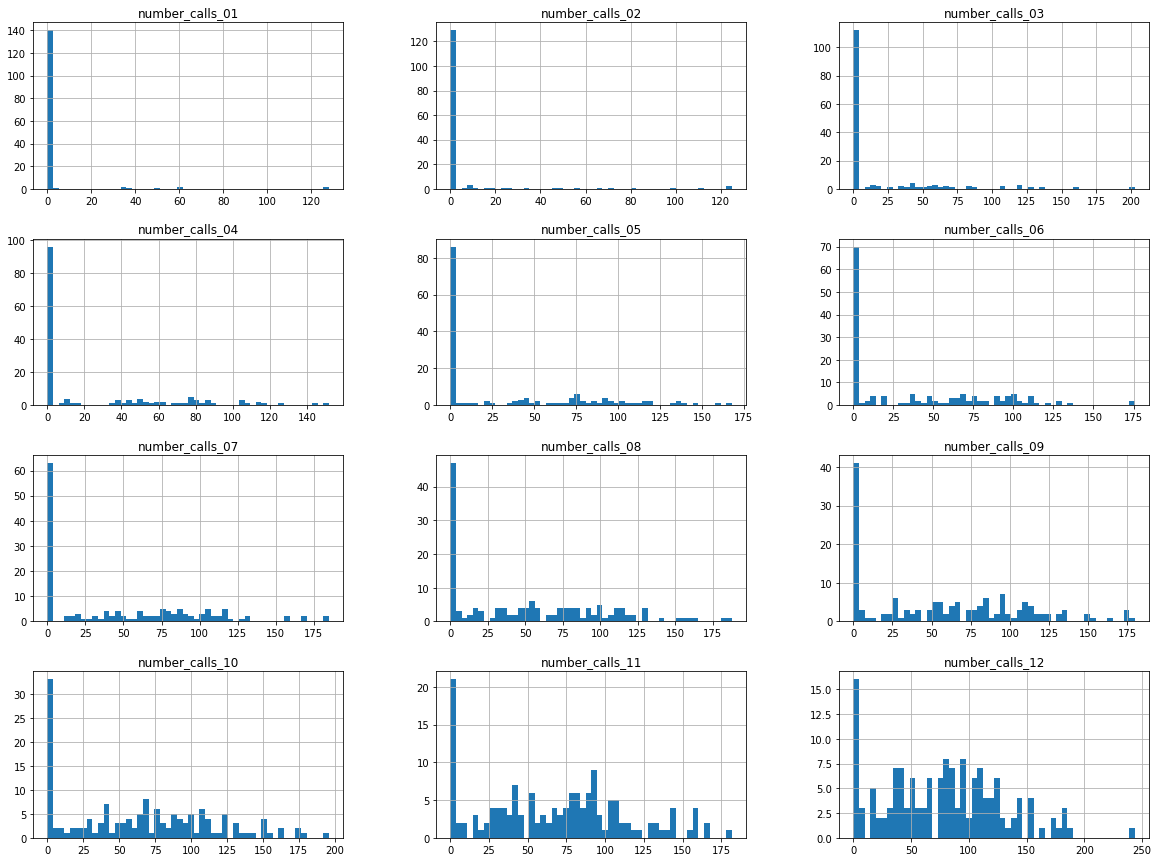

In [128]:
count_calls_ultra.hist(bins=50,figsize=(20, 15))

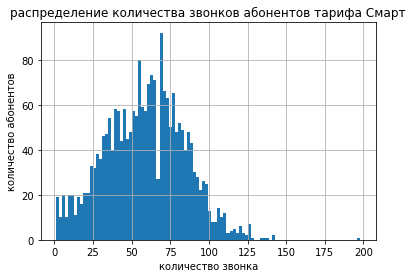

In [239]:
total_count_calls_smart = pd.concat([general_smart['number_calls_12'],general_smart['number_calls_01'],general_smart['number_calls_02'],general_smart['number_calls_03'],general_smart['number_calls_04'],general_smart['number_calls_05'],general_smart['number_calls_06'],general_smart['number_calls_07'],general_smart['number_calls_08'],general_smart['number_calls_09'],general_smart['number_calls_10'],general_smart['number_calls_11']])
total_count_calls_smart = total_count_calls_smart.loc[~(total_count_calls_smart==0)]
frame = {'count_calls_smart' : total_count_calls_smart}
total_count_calls_smart_df = pd.DataFrame(frame)
total_count_calls_smart_df.hist(bins=100)
plt.title("распределение количества звонков абонентов тарифа Смарт"); 
plt.xlabel("количество звонка")
plt.ylabel("количество абонентов")
plt.show()

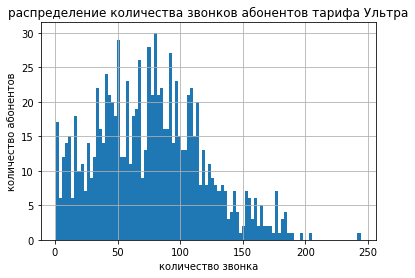

In [240]:
total_count_calls_ultra = pd.concat([general_ultra['number_calls_12'],general_ultra['number_calls_01'],general_ultra['number_calls_02'],general_ultra['number_calls_03'],general_ultra['number_calls_04'],general_ultra['number_calls_05'],general_ultra['number_calls_06'],general_ultra['number_calls_07'],general_ultra['number_calls_08'],general_ultra['number_calls_09'],general_ultra['number_calls_10'],general_ultra['number_calls_11']])
total_count_calls_ultra = total_count_calls_ultra.loc[~(total_count_calls_ultra==0)]
frame = {'count_calls_ultra' : total_count_calls_ultra}
total_count_calls_ultra_df = pd.DataFrame(frame)
total_count_calls_ultra_df.hist(bins=100)
plt.title("распределение количества звонков абонентов тарифа Ультра"); 
plt.xlabel("количество звонка")
plt.ylabel("количество абонентов")
plt.show()

In [131]:
total_count_calls_ultra.median()

75.0

In [132]:
total_count_calls_ultra.mean()

76.01682439537329

In [133]:
total_count_calls_smart.median()

60.0

In [134]:
total_count_calls_smart.mean()

58.62123256860099

In [135]:
variance_count_calls_smart = np.var(total_count_calls_smart,ddof=1)
variance_count_calls_smart

665.4388289031347

In [136]:
variance_count_calls_ultra = np.var(total_count_calls_ultra,ddof=1)
variance_count_calls_ultra

1798.0439271680752

In [137]:
standart_deviation_count_calls_smart = np.std(total_count_calls_smart,ddof=1)
standart_deviation_count_calls_smart

25.796101040721922

In [138]:
standart_deviation_count_calls_ultra = np.std(total_count_calls_ultra,ddof=1)
standart_deviation_count_calls_ultra

42.40334806554873

В целом отличие в том, что тарифом Ультра пользуются люди, которые звонят чаще, в среднем произвдят на 15 звонков в месяц больше, чем абоненты тарифа Смарт. Учитывая, что средний расход минут в месяц у абонентов тарифа Ультра выше, а распределения идентичны и медианы со средним равны по целым, но средняя месячная длительность разговоров у абонентов тарифа Ультра выше - 15 (звонков разницы) * 7 (минут - медиана) = 105 - как раз получим эту разницу.

36% абонентов тарифа Смарт превышают лимит предоставленного пакета минут.


#### Далее изучаем метрику "сообщения" обоих тарифных планов. 

In [139]:
messages_smart = general_smart[['count_message_01','count_message_02','count_message_03','count_message_04','count_message_05','count_message_06','count_message_07','count_message_08','count_message_09','count_message_10','count_message_11','count_message_12']]
messages_ultra = general_ultra[['count_message_01','count_message_02','count_message_03','count_message_04','count_message_05','count_message_06','count_message_07','count_message_08','count_message_09','count_message_10','count_message_11','count_message_12']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC50921F48>,
      dtype=object)

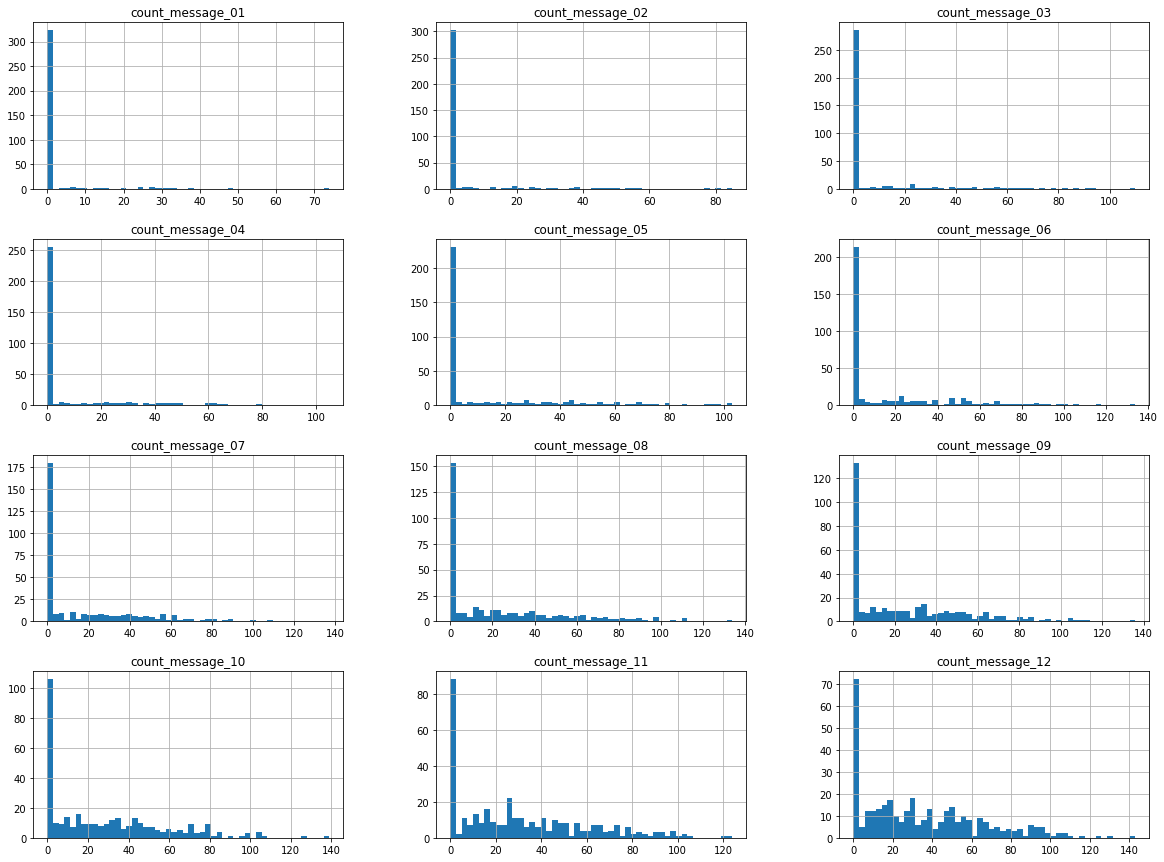

In [140]:
messages_smart.hist(bins=50,figsize=(20, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC5DC5D308>,
      dtype=object)

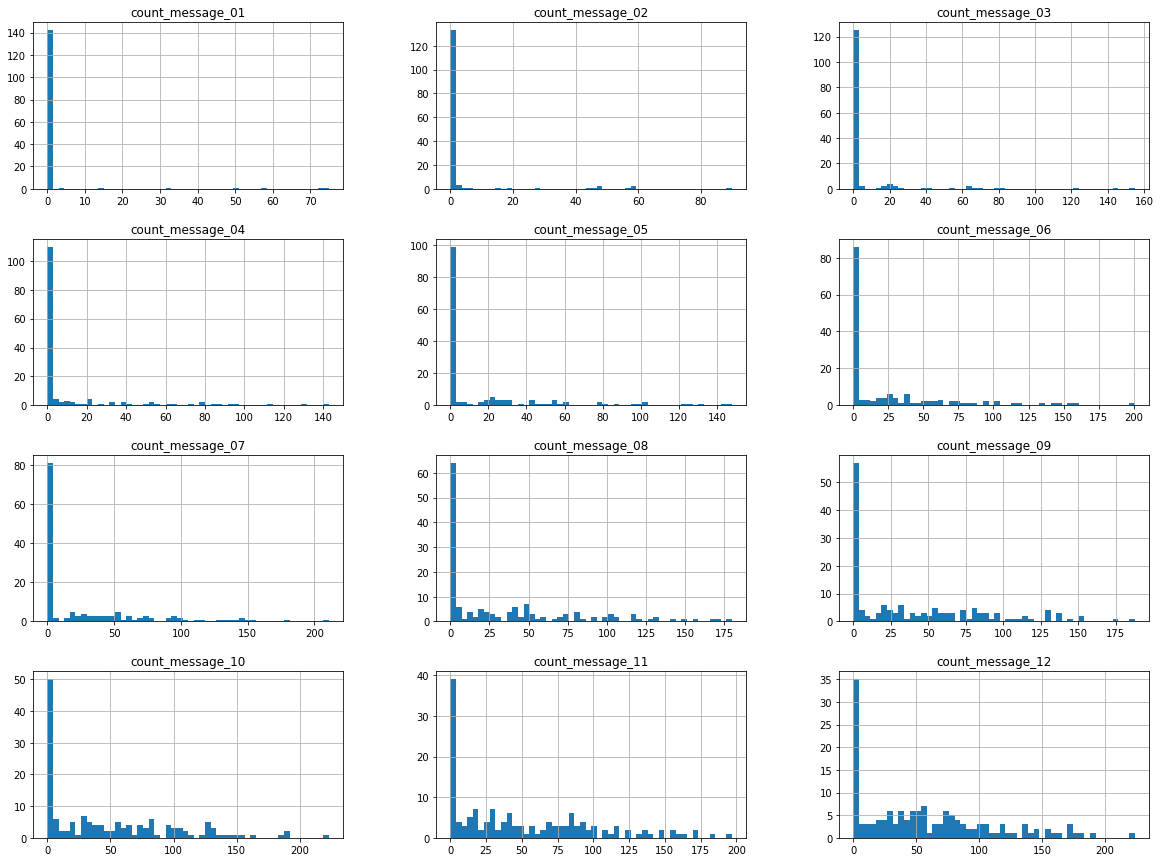

In [141]:
messages_ultra.hist(bins=50,figsize=(20, 15))

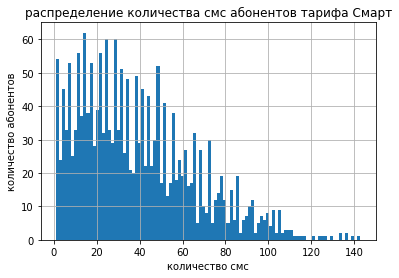

In [241]:
total_messages_smart = pd.concat([general_smart['count_message_12'],general_smart['count_message_01'],general_smart['count_message_02'],general_smart['count_message_03'],general_smart['count_message_04'],general_smart['count_message_05'],general_smart['count_message_06'],general_smart['count_message_07'],general_smart['count_message_08'],general_smart['count_message_09'],general_smart['count_message_10'],general_smart['count_message_11']])
total_messages_smart = total_messages_smart.loc[~(total_messages_smart==0)]
frame = {'count_messages_smart' : total_messages_smart}
total_messages_smart_df = pd.DataFrame(frame)
total_messages_smart_df.hist(bins=100)
plt.title("распределение количества смс абонентов тарифа Смарт"); 
plt.xlabel("количество смс")
plt.ylabel("количество абонентов")
plt.show()

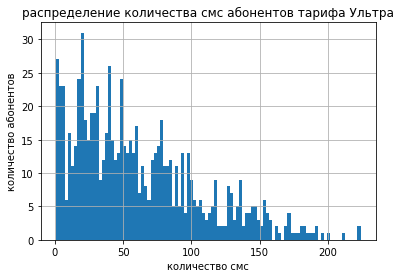

In [242]:
total_messages_ultra = pd.concat([general_ultra['count_message_12'],general_ultra['count_message_01'],general_ultra['count_message_02'],general_ultra['count_message_03'],general_ultra['count_message_04'],general_ultra['count_message_05'],general_ultra['count_message_06'],general_ultra['count_message_07'],general_ultra['count_message_08'],general_ultra['count_message_09'],general_ultra['count_message_10'],general_ultra['count_message_11']])
total_messages_ultra = total_messages_ultra.loc[~(total_messages_ultra==0)]
frame = {'count_messages_ultra' : total_messages_ultra}
total_messages_ultra_df = pd.DataFrame(frame)
total_messages_ultra_df.hist(bins=100)
plt.title("распределение количества смс абонентов тарифа Ультра"); 
plt.xlabel("количество смс")
plt.ylabel("количество абонентов")
plt.show()

Не верю своим глазам, точнее - им верю, предоставленной информации не верю! Неужели кто-то пользуется сообщениями? Оказывается - да, ещё превышают лимит и платят по 3 р за шт.

In [144]:
total_messages_smart_df.describe()

,count_messages_smart
count,1922.000000
mean,38.716441
std,26.787949
min,1.000000
25%,17.000000
50%,34.000000
75%,55.000000
max,143.000000


In [145]:
more_50_mess_smart = total_messages_smart_df.query('count_messages_smart > 50')

In [146]:
len(more_50_mess_smart)/len(total_messages_smart_df)

0.2934443288241415

29% абонентов тарифа Смарт превысили лимит бесплатных сообщений. Абоненты же тарифа Ультра едва расходуют 20% бесплатных сообщений.

In [147]:
total_messages_ultra_df.describe()

,count_messages_ultra
count,795.000000
mean,61.161006
std,45.931026
min,1.000000
25%,24.000000
50%,51.000000
75%,87.500000
max,224.000000


In [148]:
total_messages_ultra.median()

51.0

In [149]:
total_messages_ultra.mean()

61.161006289308176

In [150]:
total_messages_smart.median()

34.0

In [151]:
total_messages_smart.mean()

38.71644120707596

In [152]:
variance_messages_smart = np.var(total_messages_smart,ddof=1)
variance_messages_smart

717.594201175356

In [153]:
variance_messages_ultra = np.var(total_messages_ultra,ddof=1)
variance_messages_ultra

2109.659182865199

In [154]:
standart_deviation_messages_smart = np.std(total_messages_smart,ddof=1)
standart_deviation_messages_smart

26.78794880492637

In [155]:
standart_deviation_messages_ultra = np.std(total_messages_ultra,ddof=1)
standart_deviation_messages_ultra

45.93102636416042

30% абонентов тарифа Смарт вышли за предел бесплатных сообщений. В среднем абоненты тарифа Ультра отправляют 50 сообщений в месяц, тарифа Смарт - 35.

#### Работаем с последней оставшейся метрикой - "интернет-трафик"

In [156]:
internet_smart = general_smart[['mb_used_month_01','mb_used_month_02','mb_used_month_03','mb_used_month_04','mb_used_month_05','mb_used_month_06','mb_used_month_07','mb_used_month_08','mb_used_month_09','mb_used_month_10','mb_used_month_11','mb_used_month_12']]
internet_ultra = general_ultra[['mb_used_month_01','mb_used_month_02','mb_used_month_03','mb_used_month_04','mb_used_month_05','mb_used_month_06','mb_used_month_07','mb_used_month_08','mb_used_month_09','mb_used_month_10','mb_used_month_11','mb_used_month_12']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC50925088>,
      dtype=object)

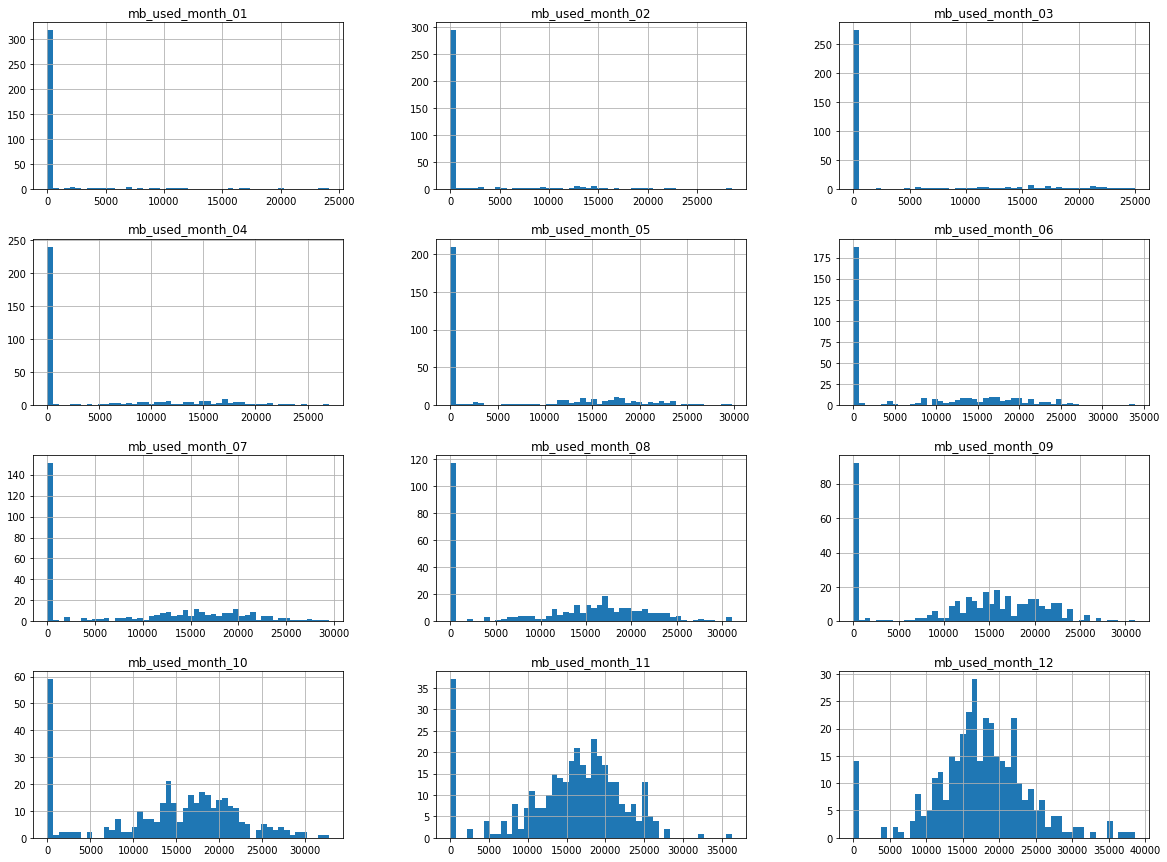

In [157]:
internet_smart.hist(bins=50,figsize=(20, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC60DC1108>,
      dtype=object)

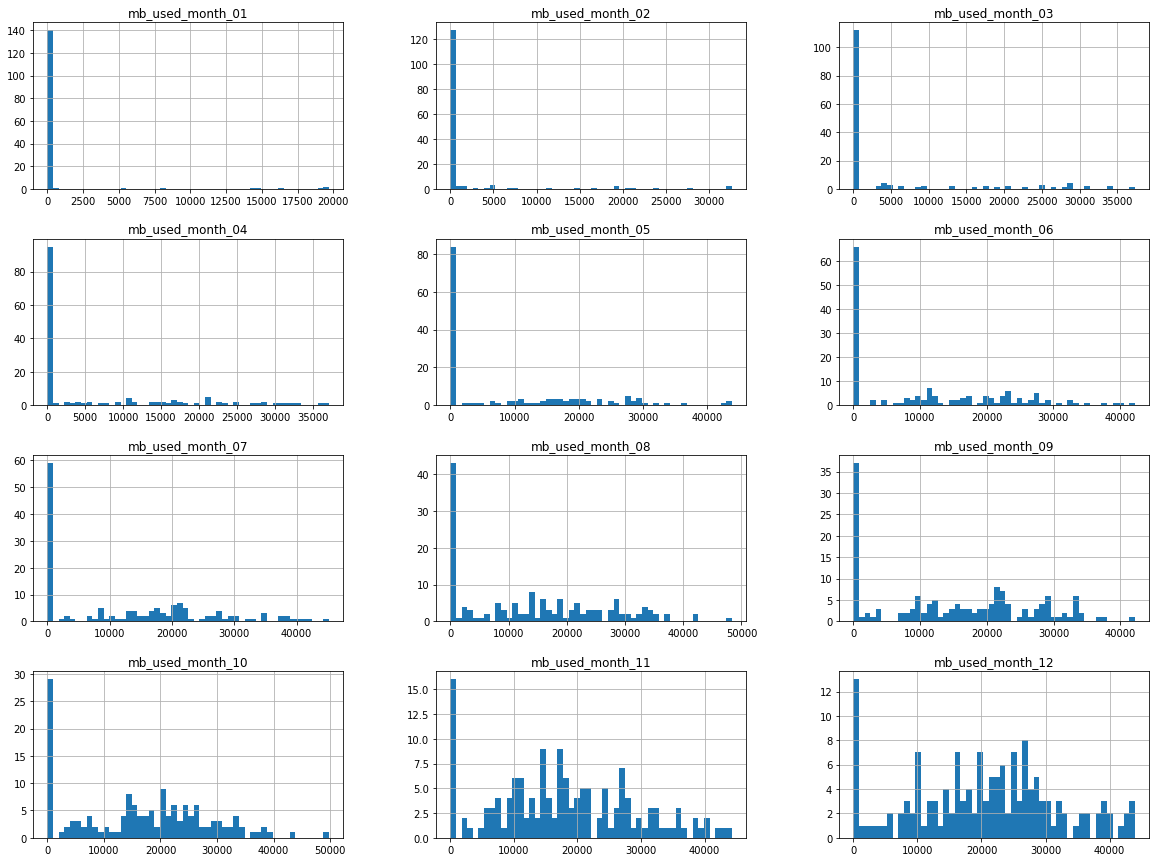

In [158]:
internet_ultra.hist(bins=50,figsize=(20, 15))

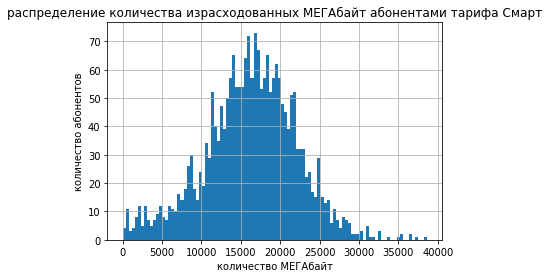

In [243]:
total_internet_smart = pd.concat([general_smart['mb_used_month_12'],general_smart['mb_used_month_01'],general_smart['mb_used_month_02'],general_smart['mb_used_month_03'],general_smart['mb_used_month_04'],general_smart['mb_used_month_05'],general_smart['mb_used_month_06'],general_smart['mb_used_month_07'],general_smart['mb_used_month_08'],general_smart['mb_used_month_09'],general_smart['mb_used_month_10'],general_smart['mb_used_month_11']])
total_internet_smart = total_internet_smart.loc[~(total_internet_smart==0)]
frame = {'count_internet_smart' : total_internet_smart}
total_internet_smart_df = pd.DataFrame(frame)
total_internet_smart_df.hist(bins=100)
plt.title("распределение количества израсходованных МЕГАбайт абонентами тарифа Смарт"); 
plt.xlabel("количество МЕГАбайт")
plt.ylabel("количество абонентов")
plt.show()

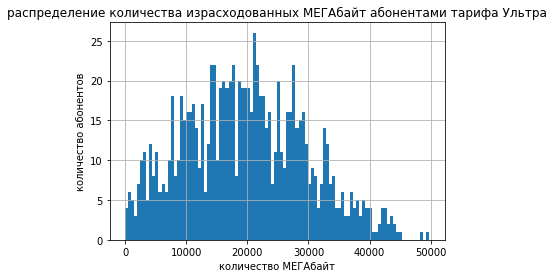

In [244]:
total_internet_ultra = pd.concat([general_ultra['mb_used_month_12'],general_ultra['mb_used_month_01'],general_ultra['mb_used_month_02'],general_ultra['mb_used_month_03'],general_ultra['mb_used_month_04'],general_ultra['mb_used_month_05'],general_ultra['mb_used_month_06'],general_ultra['mb_used_month_07'],general_ultra['mb_used_month_08'],general_ultra['mb_used_month_09'],general_ultra['mb_used_month_10'],general_ultra['mb_used_month_11']])
total_internet_ultra = total_internet_ultra.loc[~(total_internet_ultra==0)]
frame = {'count_internet_ultra' : total_internet_ultra}
total_internet_ultra_df = pd.DataFrame(frame)
total_internet_ultra_df.hist(bins=100)
plt.title("распределение количества израсходованных МЕГАбайт абонентами тарифа Ультра"); 
plt.xlabel("количество МЕГАбайт")
plt.ylabel("количество абонентов")
plt.show()

In [161]:
total_internet_smart_df.describe()

,count_internet_smart
count,2228.000000
mean,16244.472172
std,5871.037024
min,1.000000
25%,12673.250000
50%,16541.500000
75%,20078.750000
max,38627.000000


In [162]:
more_15_gb = total_internet_smart_df.query('count_internet_smart > 15000')

In [163]:
len(more_15_gb)/len(total_internet_smart_df)

0.6063734290843806

Пожалуй это самая дорогой и недостающий компонент тарифа. В 60% случаев за год абонентам не хватило вложенного интернет трафика.

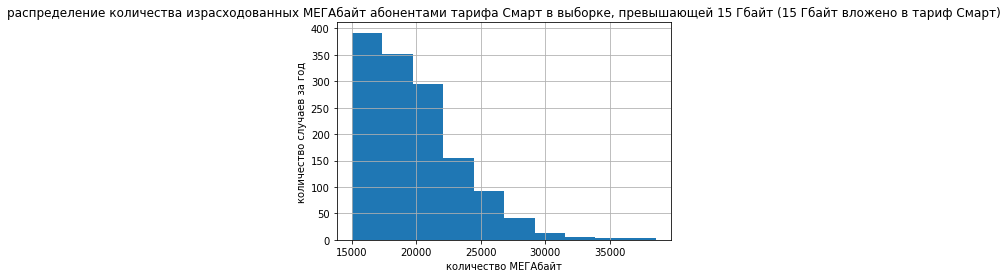

In [246]:
more_15_gb.hist()
plt.title("распределение количества израсходованных МЕГАбайт абонентами тарифа Смарт в выборке, превышающей 15 Гбайт (15 Гбайт вложено в тариф Смарт)"); 
plt.xlabel("количество МЕГАбайт")
plt.ylabel("количество случаев за год")
plt.show()

In [165]:
more_15_gb['count_internet_smart'].value_counts(bins=15, normalize=True)

(16586.333, 18160.667]    0.188749
(14988.384, 16586.333]    0.182828
(18160.667, 19735.0]      0.179127
(19735.0, 21309.333]      0.144338
(21309.333, 22883.667]    0.121392
(22883.667, 24458.0]      0.065877
(24458.0, 26032.333]      0.055514
(26032.333, 27606.667]    0.026647
(27606.667, 29181.0]      0.016284
(29181.0, 30755.333]      0.005922
(30755.333, 32329.667]    0.005181
(33904.0, 35478.333]      0.002961
(32329.667, 33904.0]      0.002221
(37052.667, 38627.0]      0.001480
(35478.333, 37052.667]    0.001480
Name: count_internet_smart, dtype: float64

In [166]:
total_internet_ultra_df.describe()

,count_internet_ultra
count,975.000000
mean,19688.587692
std,9952.830482
min,1.000000
25%,12022.000000
50%,19416.000000
75%,26921.500000
max,49793.000000


In [167]:
more_30_gb = total_internet_ultra_df.query('count_internet_ultra > 30000')

In [168]:
len(more_30_gb)/len(total_internet_ultra_df)

0.1517948717948718

In [169]:
more_40_gb = total_internet_ultra_df.query('count_internet_ultra > 40000')

In [170]:
len(more_40_gb)/len(total_internet_ultra_df)

0.02564102564102564

До интернет трафика, абоненты тарифа Ультра расходовали лишь 20% вложенных сообщений и едва превышали половину вложенных минут, но интернета не хватает всем, в т.ч. и абонентам тарифа Ультра. 15% абонентов так или иначе столкнулись с проблемой, что им не хватает вложенного в абонентскую плату трафика интернета, это меньше в 4 раза, чем ситуация с тарифом Смарт. Тут 75% абонентов вполне хватает вложенного трафика.

In [171]:
total_internet_smart.median()

16541.5

In [172]:
total_internet_smart.mean()

16244.472172351885

In [173]:
total_internet_ultra.median()

19416.0

In [174]:
total_internet_ultra.mean()

19688.587692307694

In [175]:
variance_internet_smart = np.var(total_internet_smart,ddof=1)
variance_internet_smart

34469075.7383362

In [176]:
variance_internet_ultra = np.var(total_internet_ultra,ddof=1)
variance_internet_ultra

99058834.60600856

In [177]:
standart_deviation_internet_smart = np.std(total_internet_smart,ddof=1)
standart_deviation_internet_smart

5871.03702409857

In [178]:
standart_deviation_internet_ultra = np.std(total_internet_ultra,ddof=1)
standart_deviation_internet_ultra

9952.830482129622

"Нужно больше интернета".

Особенно абонентам тарифа Смарт. Медианы и средние, наудивление, почти сошлись, прямо таки наглядное нормальное распределение. У тарифа Ультра - 19Гб, Смарт - 16Гб. Разница в 3Гб, возможно, связана лишь с тем, что у абонентов тарифа Ультра просто больше трафика.

#### Вывод по шагу 3

Изучены распределения, предпочтения, особенности тарифных планов и абонентов. Выводы писал по ходу выполнения задачи, поэтому не буду копировать и вставлять повторно их сюда.

## Шаг 4. Проверка гипотез

Давайте начнем с простого и посмотрим на прибыль Мегалайна также как мы смотрели на предыдущие метрики.

In [179]:
profit_smart = general_smart[['profit_01','profit_02','profit_03','profit_04','profit_05','profit_06','profit_07','profit_08','profit_09','profit_10','profit_11','profit_12']]
profit_ultra = general_ultra[['profit_01','profit_02','profit_03','profit_04','profit_05','profit_06','profit_07','profit_08','profit_09','profit_10','profit_11','profit_12']]

In [247]:
profit_smart

,profit_01,profit_02,profit_03,profit_04,profit_05,profit_06,profit_07,profit_08,profit_09,profit_10,profit_11,profit_12
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1350.0,550.0
2,0.0,0.0,0.0,0.0,0.0,550.0,1150.0,1750.0,950.0,550.0,1350.0,1350.0
5,550.0,550.0,928.0,1258.0,868.0,919.0,820.0,970.0,556.0,1285.0,739.0,901.0
6,0.0,550.0,1150.0,550.0,550.0,550.0,1750.0,1550.0,750.0,1550.0,550.0,1350.0
7,0.0,0.0,0.0,550.0,1150.0,724.0,1017.0,1750.0,1072.0,550.0,1232.0,550.0
...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,550.0,980.0,1150.0,1350.0,1150.0
496,550.0,3668.0,2757.0,2058.0,2350.0,1966.0,2826.0,2509.0,2950.0,3350.0,3278.0,1852.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,568.0,550.0,1724.0
498,0.0,0.0,0.0,0.0,0.0,0.0,550.0,2586.0,2150.0,1750.0,0.0,0.0


In [248]:
profit_ultra

,profit_01,profit_02,profit_03,profit_04,profit_05,profit_06,profit_07,profit_08,profit_09,profit_10,profit_11,profit_12
0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0
4,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...
476,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
491,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,3900.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC61900688>,
      dtype=object)

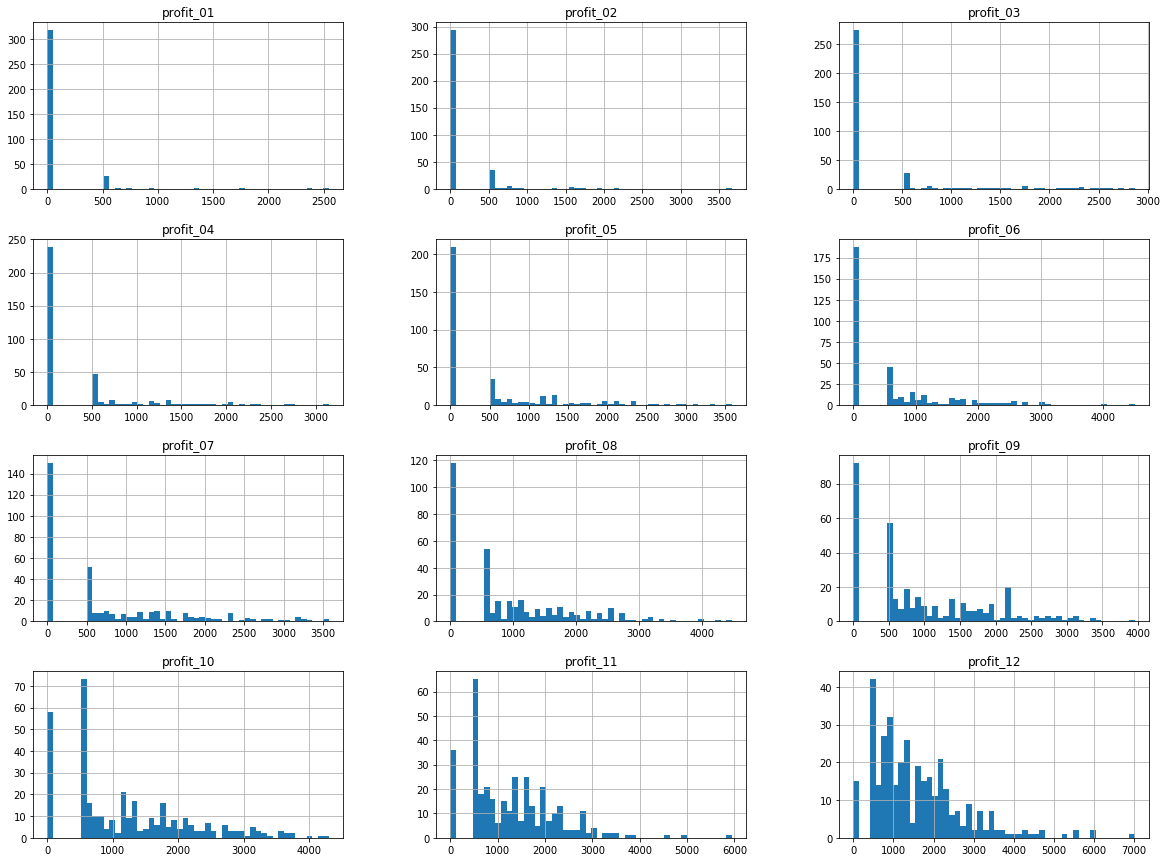

In [180]:
profit_smart.hist(bins=50,figsize=(20, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC62FE4E88>,
      dtype=object)

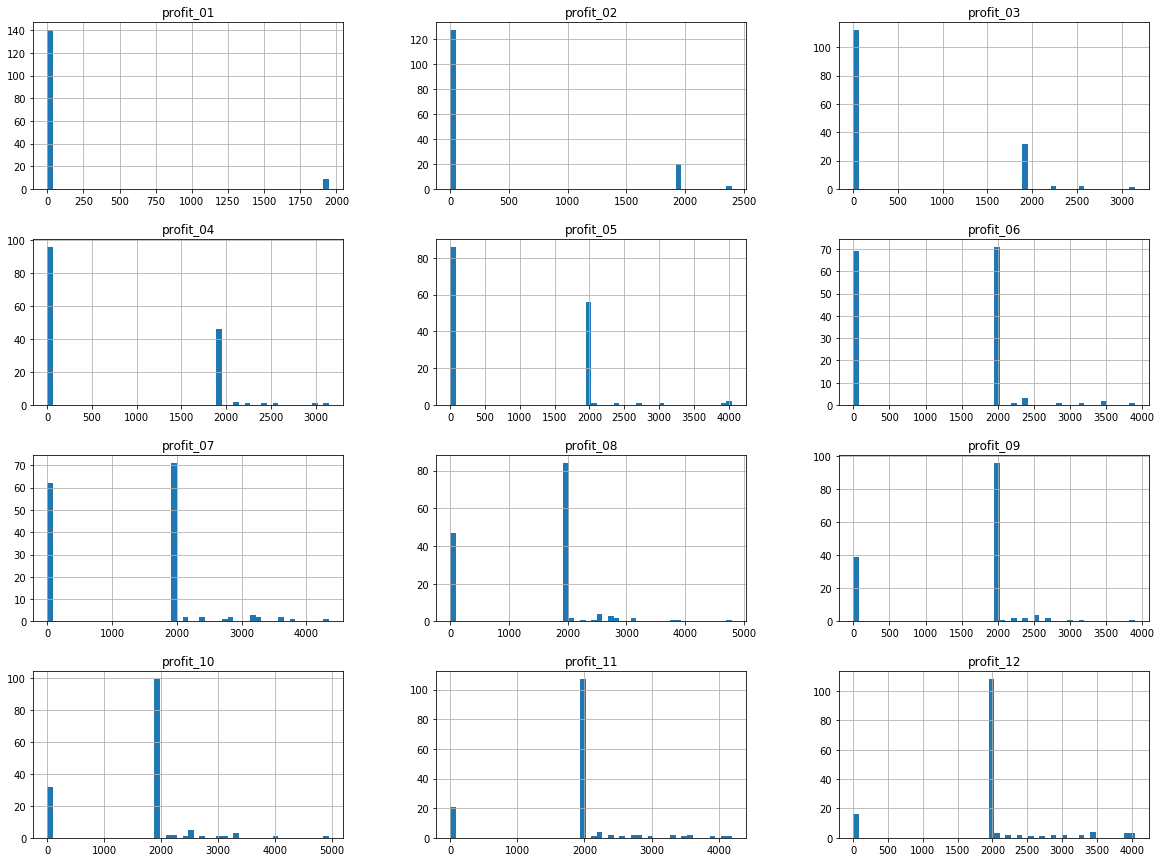

In [181]:
profit_ultra.hist(bins=50,figsize=(20, 15))

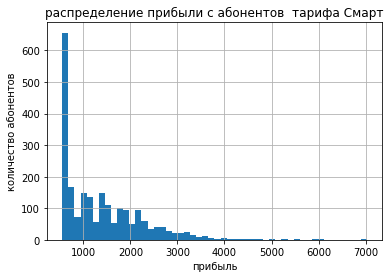

In [249]:
total_profit_smart = pd.concat([general_smart['profit_12'],general_smart['profit_01'],general_smart['profit_02'],general_smart['profit_03'],general_smart['profit_04'],general_smart['profit_05'],general_smart['profit_06'],general_smart['profit_07'],general_smart['profit_08'],general_smart['profit_09'],general_smart['profit_10'],general_smart['profit_11']])
total_profit_smart = total_profit_smart.loc[~(total_profit_smart==0)]
frame = {'total_profit_smart' : total_profit_smart}
total_profit_smart_df = pd.DataFrame(frame)
total_profit_smart_df.hist(bins=50)
plt.title("распределение прибыли с абонентов  тарифа Смарт"); 
plt.xlabel("прибыль")
plt.ylabel("количество абонентов")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC6481CDC8>]],
      dtype=object)

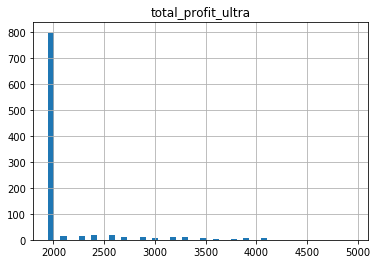

In [183]:
total_profit_ultra = pd.concat([general_ultra['profit_12'],general_ultra['profit_01'],general_ultra['profit_02'],general_ultra['profit_03'],general_ultra['profit_04'],general_ultra['profit_05'],general_ultra['profit_06'],general_ultra['profit_07'],general_ultra['profit_08'],general_ultra['profit_09'],general_ultra['profit_10'],general_ultra['profit_11']])
total_profit_ultra = total_profit_ultra.loc[~(total_profit_ultra==0)]
frame = {'total_profit_ultra' : total_profit_ultra}
total_profit_ultra_df = pd.DataFrame(frame)
total_profit_ultra_df.hist(bins=50)
plt.title("распределение прибыли с абонентов  тарифа Ультра"); 
plt.xlabel("прибыль")
plt.ylabel("количество абонентов")
plt.show()

In [257]:
total_profit_smart_df['total_profit_smart'].value_counts(normalize=True).head(10)

550.0     0.236274
1350.0    0.036004
750.0     0.033303
950.0     0.032853
1150.0    0.032853
1550.0    0.030603
1750.0    0.022952
1950.0    0.019352
2150.0    0.017102
2350.0    0.013051
Name: total_profit_smart, dtype: float64

In [184]:
total_profit_ultra_df['total_profit_ultra'].value_counts(normalize=True)#.plot.pie(y='total_profit_ultra', figsize=(5, 5))

1950.0    0.849097
2550.0    0.019129
2400.0    0.018066
2250.0    0.015940
2100.0    0.014878
2700.0    0.011690
3150.0    0.010627
2850.0    0.009564
3300.0    0.009564
3900.0    0.008502
3450.0    0.007439
4050.0    0.007439
3000.0    0.007439
3600.0    0.004251
3750.0    0.002125
4200.0    0.001063
4350.0    0.001063
4950.0    0.001063
4800.0    0.001063
Name: total_profit_ultra, dtype: float64

In [186]:
total_profit_smart_df['total_profit_smart'].value_counts(bins=10, normalize=True)

(543.525, 1197.4]    0.531053
(1197.4, 1844.8]     0.209271
(1844.8, 2492.2]     0.148965
(2492.2, 3139.6]     0.067507
(3139.6, 3787.0]     0.030153
(3787.0, 4434.4]     0.006751
(4434.4, 5081.8]     0.003150
(5729.2, 6376.6]     0.001350
(5081.8, 5729.2]     0.001350
(6376.6, 7024.0]     0.000450
Name: total_profit_smart, dtype: float64

Интересное наблюдение. Лишь 23% абонентов тарифа Smart заплатили чисто абонентскую плату. 50% (то есть ещё 27%) - уложились в 1000p. 22% абонентов заплатили больше, чем стоимость тарифа Ultra. Стоит посмотреть - превысили ли они бесплатный пакет услуг тарифа Ultra, а если превысили - посчитать во сколько бы обошлось им это, если бы они пользовались тарифом Ultra.

Но перед этим, давайте посмотрим на средние и медиану, дисперсию и стандартное отклонение.

In [187]:
median_profit_smart = total_profit_smart_df.median()
median_profit_smart

total_profit_smart    1150.0
dtype: float64

In [188]:
mean_profit_smart = total_profit_smart_df.mean()
mean_profit_smart

total_profit_smart    1370.090009
dtype: float64

In [189]:
median_profit_ultra = total_profit_ultra_df.median()
median_profit_ultra

total_profit_ultra    1950.0
dtype: float64

In [190]:
mean_profit_ultra = total_profit_ultra_df.mean()
mean_profit_ultra

total_profit_ultra    2092.82678
dtype: float64

Абоненты тарифа Smart как правило превышают расход услуг своего пакета, и в лучшем случае платят двойную цену своего тарифа в месяц.

In [191]:
variance_profit_smart = np.var(total_profit_smart,ddof=1)
variance_profit_smart

753781.1958568962

In [192]:
standart_deviation_profit_smart = np.std(total_profit_smart,ddof=1)
standart_deviation_profit_smart

868.2057336005656

In [193]:
variance_profit_ultra = np.var(total_profit_ultra,ddof=1)
variance_profit_ultra

177387.31996291745

In [194]:
standart_deviation_profit_ultra= np.std(total_profit_ultra,ddof=1)
standart_deviation_profit_ultra

421.1737408278411

In [195]:
expensive_smart = general_smart.query('profit_11 > 1950' or 'profit_12 > 1950'or 'profit_10 > 1950'or 'profit_09 > 1950'or 'profit_08 > 1950'or 'profit_07 > 1950'or 'profit_06 > 1950'or 'profit_05 > 1950'or 'profit_04 > 1950' or 'profit_03 > 1950'or 'profit_02 > 1950'or 'profit_01 > 1950')

In [196]:
expensive_smart = expensive_smart[['profit_12','profit_11','profit_10','profit_09','profit_08','profit_07','profit_06','profit_05','profit_04','profit_03','profit_02','profit_01']]

In [197]:
pd.set_option('display.max_columns', None)
len(expensive_smart)

74

In [198]:
len(general_smart)

351

21% абонентов тарифа Смарт хотя бы раз платил больше абонентской платы тарифа Ультра. Давайте на графике посмотрим как часто они переходили порог в 1950 руб.

In [199]:
expensive_smart

,profit_12,profit_11,profit_10,profit_09,profit_08,profit_07,profit_06,profit_05,profit_04,profit_03,profit_02,profit_01
11,2150.0,2792.0,1785.0,1950.0,2043.0,1404.0,1150.0,1350.0,1350.0,550.0,0.0,0.0
12,550.0,2150.0,3550.0,1550.0,1950.0,2350.0,2550.0,2950.0,950.0,550.0,0.0,0.0
14,2759.0,2750.0,2153.0,2750.0,2950.0,3150.0,2750.0,550.0,0.0,0.0,0.0,0.0
15,1658.0,1983.0,1265.0,1004.0,3204.0,1874.0,3040.0,1219.0,550.0,0.0,0.0,0.0
27,2225.0,2550.0,2150.0,1550.0,2550.0,1550.0,550.0,2970.0,550.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
464,4172.0,2286.0,2400.0,1115.0,977.0,1059.0,1750.0,2537.0,1768.0,1891.0,550.0,0.0
477,2245.0,3360.0,2458.0,2175.0,2528.0,2825.0,2561.0,1940.0,550.0,0.0,0.0,0.0
479,2641.0,2150.0,1612.0,2883.0,1150.0,3284.0,0.0,0.0,0.0,0.0,0.0,0.0
486,7024.0,5952.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**то есть 74 абонента тарифа Смарт периодично превышают стоимость абон.платы тарифа Ультра.**

In [200]:
e_x = expensive_smart.T

In [201]:
e_x

,11,12,14,15,27,32,33,45,46,47,52,58,61,65,68,72,77,92,93,98,105,107,119,135,138,146,149,162,172,173,189,213,229,233,239,246,251,261,262,288,301,305,313,314,319,324,332,339,354,365,386,388,390,395,400,410,420,421,426,432,439,441,443,447,448,449,456,460,462,464,477,479,486,496
profit_12,2150.0,550.0,2759.0,1658.0,2225.0,1350.0,2016.0,1550.0,2169.0,4254.0,1828.0,1628.0,1759.0,550.0,855.0,3750.0,3453.0,2577.0,3909.0,5265.0,2846.0,1350.0,1550.0,1350.0,2906.0,1291.0,2619.0,750.0,2350.0,2301.0,1186.0,1383.0,4382.0,2314.0,1550.0,2150.0,2094.0,5956.0,1350.0,874.0,2835.0,2230.0,3408.0,750.0,2968.0,2791.0,1392.0,2134.0,3276.0,4659.0,1756.0,2037.0,2150.0,1376.0,2343.0,750.0,3350.0,550.0,2248.0,2200.0,1950.0,2950.0,1146.0,3181.0,1550.0,988.0,4294.0,1126.0,3771.0,4172.0,2245.0,2641.0,7024.0,1852.0
profit_11,2792.0,2150.0,2750.0,1983.0,2550.0,2350.0,2816.0,2413.0,2151.0,3862.0,2324.0,2264.0,2214.0,2309.0,2750.0,1974.0,2159.0,3010.0,2532.0,2106.0,3037.0,2150.0,2350.0,2350.0,2073.0,2306.0,2822.0,2150.0,2285.0,3367.0,1969.0,1976.0,3559.0,2119.0,2230.0,2750.0,2652.0,4969.0,2950.0,2484.0,2070.0,3222.0,3505.0,2350.0,2046.0,2364.0,2318.0,2706.0,3070.0,2767.0,2750.0,2619.0,2350.0,2018.0,3088.0,2939.0,2750.0,2550.0,2750.0,2484.0,2150.0,2750.0,1990.0,2063.0,2076.0,1971.0,4568.0,2181.0,3715.0,2286.0,3360.0,2150.0,5952.0,3278.0
profit_10,1785.0,3550.0,2153.0,1265.0,2150.0,550.0,1640.0,550.0,2550.0,550.0,2181.0,1375.0,1259.0,1996.0,3620.0,2225.0,550.0,2553.0,2764.0,2074.0,3610.0,750.0,2783.0,1350.0,3193.0,1475.0,2031.0,550.0,4150.0,2830.0,3133.0,1246.0,550.0,3768.0,750.0,1750.0,3097.0,550.0,1550.0,616.0,1892.0,550.0,550.0,2291.0,2922.0,4303.0,1198.0,1708.0,1407.0,550.0,2550.0,2950.0,950.0,2083.0,3182.0,1750.0,3750.0,1959.0,2673.0,2859.0,1150.0,0.0,3199.0,1857.0,550.0,1262.0,3404.0,1637.0,550.0,2400.0,2458.0,1612.0,550.0,3350.0
profit_09,1950.0,1550.0,2750.0,1004.0,1550.0,1416.0,2831.0,756.0,810.0,0.0,2848.0,0.0,1575.0,3422.0,2190.0,3107.0,0.0,2568.0,1657.0,2750.0,550.0,550.0,1550.0,1706.0,3025.0,670.0,2897.0,0.0,2150.0,953.0,1397.0,2186.0,0.0,2484.0,550.0,550.0,1879.0,0.0,1750.0,550.0,550.0,0.0,0.0,1043.0,2548.0,3328.0,1150.0,1750.0,1595.0,0.0,3959.0,2150.0,1350.0,607.0,1553.0,2150.0,550.0,2186.0,1868.0,3136.0,3350.0,0.0,550.0,550.0,550.0,1231.0,2426.0,949.0,0.0,1115.0,2175.0,2883.0,0.0,2950.0
profit_08,2043.0,1950.0,2950.0,3204.0,2550.0,2550.0,2231.0,2389.0,550.0,0.0,2017.0,0.0,2403.0,2859.0,3167.0,3350.0,0.0,1034.0,2535.0,3950.0,0.0,2350.0,953.0,1845.0,4478.0,1679.0,2697.0,0.0,3150.0,2534.0,1364.0,550.0,0.0,2302.0,1568.0,0.0,2758.0,0.0,1750.0,0.0,0.0,0.0,0.0,2750.0,550.0,3505.0,1350.0,550.0,550.0,0.0,750.0,550.0,1350.0,1487.0,550.0,550.0,0.0,1750.0,0.0,574.0,2438.0,0.0,0.0,0.0,0.0,1050.0,550.0,1136.0,0.0,977.0,2528.0,1150.0,0.0,2509.0
profit_07,1404.0,2350.0,3150.0,1874.0,1550.0,1550.0,550.0,1171.0,0.0,0.0,550.0,0.0,550.0,1807.0,550.0,2549.0,0.0,2789.0,1415.0,1959.0,0.0,550.0,1750.0,1550.0,750.0,2097.0,3055.0,0.0,3550.0,3578.0,1866.0,0.0,0.0,2352.0,550.0,0.0,2470.0,0.0,1550.0,0.0,0.0,0.0,0.0,2629.0,0.0,2725.0,1365.0,0.0,0.0,0.0,0.0,0.0,550.0,930.0,0.0,0.0,0.0,1989.0,0.0,0.0,1750.0,0.0,0.0,0.0,0.0,550.0,0.0,937.0,0.0,1059.0,2825.0,3284.0,0.0,2826.0
profit_06,1150.0,2550.0,2750.0,3040.0,550.0,1550.0,0.0,995.0,0.0,0.0,0.0,0.0,0.0,2210.0,0.0,1550.0,0.0,550.0,550.0,550.0,0.0,0.0,1950.0,1587.0,0.0,802.0,2473.0,0.0,4515.0,550.0,1543.0,0.0,0.0,3016.0,550.0,0.0,3052.0,0.0,950.0,0.0,0.0,0.0,0.0,2150.0,0.0,4045.0,2101.0,0.0,0.0,0.0,0.0,0.0,0.0,1709.0,0.0,0.0,0.0,756.0,0.0,0.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,1156.0,0.0,1750.0,2561.0,0.0,0.0,1966.0
profit_05,1350.0,2950.0,550.0,1219.0,2970.0,1228.0,0.0,2165.0,0.0,0.0,0.0,0.0,0.0,3593.0,0.0,3350.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,950.0,0.0,550.0,550.0,0.0,2750.0,0.0,1599.0,0.0,0.0,550.0,0.0,0.0,2888.0,0.0,2150.0,0.0,0.0,0.0,0.0,2641.0,0.0,550.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,750.0,0.0,0.0,0.0,1750.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1363.0,0.0,2537.0,1940.0,0.0,0.0,2350.0
profit_04,1350.0,950.0,0.0,550.0,550.0,1061.0,

При просмотре сгруппированных данных можно прийти к выводу, что 21% абонентов из выборки почти с самого подключения существенно превышают значение абонентской платы так сильно, как никто не превысил из абонентов тарифа Ультра. Причём, это не разовый перерасход бесплатного пакета, а почти ежемесячная.

Вероятно, таким абонентам стоит предложить перейти на тариф Ультра, где бесплатный пакет шире, чем у тарифа Смарт, а сверх пакета - тарификация дешевле, чтобы месячная оплата тарифа менее напрягала абонента и он не ушёл к конкурентам.

Также можно заметить, что большей части абонентов тарифа Смарт не хватает их бесплатного пакета, в первую очередь - это интернет трафик. Уже у 32% - это использование трафика с 20Гб до 25Гб, а это доплата сверх абонентской от 5*200=1000р. до 2000р.

### формулируем и проверяем гипотезу касательно средней выручки тарифов Smart и Ultra.

Мы имеем медианы доходов тарифов Смарт и Ультра:

median_profit_smart = 1150
median_profit_ultra = 1950

и средний доход тарифов Смарт и Ультра:

mean_profit_smart = 1370
mean_profit_ultra = 2092

Глядя на них мы приходим к очевидному выводу (он же наша гипотеза) - __выручка от тарифа Ультра для оператора выше выручки от тарифа Смарт.__

Чтобы проверить гипотезу об отличии среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind, который применим к нормальным распределениям, какими и являются наши.

Мы имеем две выборки:

total_profit_ultra - выручка тарифа Ultra

total_profit_smart - выручка тарифа Smart

В работе мы будем считать,что дисперсии этих выборок отличаются, т.к. они действительно отличаются - у тарифа Смарт variance_profit_smart = 753781, у тарифа Ультра variance_profit_ultra = 177387, поэтому параметр equal_var = False.

А критический уровень статистической значимости (alpha) объявим равным 5%

In [203]:
alpha = .05
results = st.ttest_ind(total_profit_smart, total_profit_ultra, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Не получилось отвергнуть нулевую гипотезу")
else:
    print("Отвергаем нулевую гипотезу")

p-значение: 7.608245759536718e-189
Не получилось отвергнуть нулевую гипотезу


Полученное значние p-value (оно, можно сказать, стремится к нулю) говорит о том, что тут нет и тени случайности, действительно средняя выручка от тарифа Смарт ниже выручки от тарифа Ультра.

Но, давайте посмотрим глубже, посмотрим в корень.

Возможно абоненты тарифа Ультра и приносят большую выручку компании, но **абонентов тарифа Смарт больше** И это ключевой момент.

In [204]:
len(general_ultra)

149

In [205]:
len(general_smart)

351

In [206]:
general_ultra['total_profit'].sum()

1969350.0

In [207]:
general_smart['total_profit'].sum()

3044340.0

Согласно Центральной Предельной Теореме случайная выборка отражает свойства генеральной совокупности, значит отношение абонентов тарифа Ультра к абонентам тарифа Смарт составляет примерно 2/5, уже исходя из выборки прибыль приносимая тарифом Смарт на 1 млн.р. больше, то есть в 1,5 раза выше прибыли, приносимой тарифом Ультра, хотя средние у тарифа Смарт и ниже. Берут числом. 

Отсюда можно сделать вывод, что компания должна стремиться увеличить число абонентов тарифа Ультра.

### смотрим на среднюю выручку от пользователей из Москвы и выручку от пользователей из других регионов, ищем отличия, формулируем и проверяем гипотезу.

In [208]:
city_users = users[['user_id','city']]

In [209]:
general = general.join(city_users.set_index('user_id'), on='user_id')

In [210]:
moscow = general.query('city == "Москва"')
len(moscow)

99

In [211]:
other = general.query('city != "Москва"')
len(other)

401

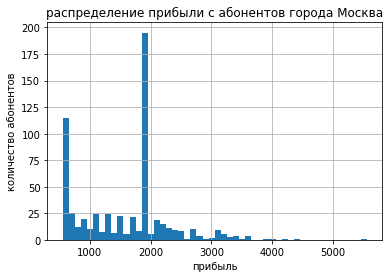

In [258]:
profit_moscow = pd.concat([moscow['profit_12'],moscow['profit_01'],moscow['profit_02'],moscow['profit_03'],moscow['profit_04'],moscow['profit_05'],moscow['profit_06'],moscow['profit_07'],moscow['profit_08'],moscow['profit_09'],moscow['profit_10'],moscow['profit_11']])
profit_moscow = profit_moscow.loc[~(profit_moscow==0)]
frame = {'profit_moscow' : profit_moscow}
profit_moscow_df = pd.DataFrame(frame)
profit_moscow_df.hist(bins=50)
plt.title("распределение прибыли с абонентов города Москва"); 
plt.xlabel("прибыль")
plt.ylabel("количество абонентов")
plt.show()

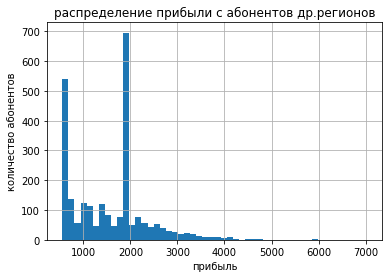

In [259]:
profit_other = pd.concat([other['profit_12'],other['profit_01'],other['profit_02'],other['profit_03'],other['profit_04'],other['profit_05'],other['profit_06'],other['profit_07'],other['profit_08'],other['profit_09'],other['profit_10'],other['profit_11']])
profit_other = profit_other.loc[~(profit_other==0)]
frame = {'profit_other' : profit_other}
profit_other_df = pd.DataFrame(frame)
profit_other_df.hist(bins=50)
plt.title("распределение прибыли с абонентов др.регионов"); 
plt.xlabel("прибыль")
plt.ylabel("количество абонентов")
plt.show()

Предлагаю сразу посмотреть на отношении тариф Смарт / тариф Ультра в регионах и Москве

In [214]:
len(moscow.query('tariff == "smart"'))

67

In [215]:
len(moscow.query('tariff == "ultra"'))

32

In [260]:
len(moscow.query('tariff == "smart"')) / len(moscow.query('tariff == "ultra"'))

2.09375

In [216]:
len(other.query('tariff == "smart"'))

284

In [217]:
len(other.query('tariff == "ultra"'))

117

In [261]:
len(other.query('tariff == "smart"')) / len(other.query('tariff == "ultra"'))

2.427350427350427

В регионах - 2.4, в Москве - 2,0. Смарт предпочитают с небольшим отрывом среди абонентов в регионах, соответственно Ультра в Москве.

In [218]:
median_profit_moscow = profit_moscow.median()
median_profit_moscow

1941.0

In [219]:
mean_profit_moscow = profit_moscow.mean()
mean_profit_moscow

1602.7967213114755

In [220]:
median_profit_other = profit_other.median()
median_profit_other

1735.0

In [221]:
mean_profit_other = profit_other.mean()
mean_profit_other

1580.8789659224442

In [222]:
variance_profit_moscow = np.var(profit_moscow,ddof=1)
variance_profit_moscow


606966.2180516295

In [223]:
variance_profit_other = np.var(profit_other,ddof=1)
variance_profit_other


711720.9026647817

Мы видим, что дисперсия в выборке среди регионов больше на 100 000, чем в Москве, то есть в 1.7 раза.

Мы имеем медианы доходов по Москве и лругим городам:

median_profit_moscow = 1941
median_profit_other = 1735

и средний доход от абонентов по Москве и другим городам:

mean_profit_moscow = 1602
mean_profit_other = 1580

Медиана и среднее доходов для ТелекомКомпании по Москве больше, чем аналогичные показатели по другим городам. Соответственно __гипотеза - выручка с абонентов выше по Москве, чем в других городах.__

Чтобы проверить гипотезу об отличии среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind.

Мы имеем две выборки:

profit_moscow - выручка по Москве

profit_other - выручка по другим городам.

В работе мы будем считать,что дисперсии этих выборок отличаются, т.к. variance_profit_moscow = 606966, у тарифа Ультра variance_profit_other = 711720, поэтому параметр equal_var = False. Но поэкспериментируем и посмотрим на результат, если укажем equal_var = True.

А критический уровень статистической значимости (alpha) объявим равным 5%

In [224]:
alpha = .05
results = st.ttest_ind(profit_moscow, profit_other)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Не получилось отвергнуть нулевую гипотезу")
else:
    print("Отвергаем нулевую гипотезу")

p-значение: 0.5587047809129086
Отвергаем нулевую гипотезу


In [225]:
alpha = .05
results = st.ttest_ind(profit_moscow, profit_other, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Не получилось отвергнуть нулевую гипотезу")
else:
    print("Отвергаем нулевую гипотезу")

p-значение: 0.5392866544898274
Отвергаем нулевую гипотезу


Мы __отвергаем гипотезу__, т.к. полученное значение p-value говорит о том, что хотя средняя выручка от абонентов в Москве и выше, чем от абонентов в других городах, с вероятностью в почти 55% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о различии между выручками Москвы и других городов.

## Шаг №5. Общий вывод.

Не буду дублировать всё напианное выше, а постараюсь чётко ответить на поставленный вопрос, а именно:

"Вы аналитик телеком компании — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей компании: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. __Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.__"

Тариф Ультра предоставляет более полный пакет бесплатных минут разговора, сообщений и интернет трафика, но у него и абонентская плата в 4 раза больше, чем у тарифа Смарт. Тариф Ультра предоставляет просто неисчерпаемое количество минут и сообщений, в то время как абоненты тарифа Смарт часто превышают лимит по количеству минут разговора и сообщений. 36% платежей за год тарифа Смарт включали в себя плату за превышение 500 минут разговора, и 30% - за превышение лимита сообщений. А вот с интернет-трафиком тарифа Смарт обстоятельства совсем плачевны, 60% платежей - были увеличены сверх абонентской платы за перерасход "пакетных" 15Гб, интернет-трафика также не всем хватало и на тарифе Ультра - 15% платежей за год включали в себя цену за превышение лимита трафика. 


Мы обращаем внимание, что в __тарифе Смарт__ по сообщениям и минутам за пределы выходят около 30% платежей, возможно так и должно быть, чтобы стимулировать абонентов выбирать более дорогостоящий тариф или получать доп.прибыль компанией. Если рассматривать 30% как целевой порог, как то, что должно быть, то предлогаю увеличить количество интернет-трафика в тарифе Смарт до 20Гб, в него укладывались 75% абонентов. Чувствуется острая нехватка трафика абонентам, чтобы они не ушли с тарифа к конкурентам, которые увеличат свой пакет на 0,5 Гб, вероятно не стоит намеренно так резко занижать бесплатные Гигабайты, причём тарификация 3х доп. Гигабайтов превышает стоимость месячной абонентской платы, а если учесть, что тариф Смарт выберут абоненты, которые не готовы платить больше и взять тариф Ультра, то возможно это их напряжёт.

__Что касается тарифа Ультра.__

В нём в 6 (3000/500=6) раз больше минут, в !20! (1000/50=20) раз больше сообщений и только в 2 раза больше интернет-трафика, хотя цена выше в 4 раза. Интернет стал таки камнем преткновения. 15% пользователям тарифа Ультра не хватило. 75% укладывается в 27Гб, но 2,5% превысило 40Гб. Если Ультра столь неисчерпаем, то может стоит и тут поднять количество трафика, если в тарифе Смарт станет 20Гб, а у тарифа Ультра Гб в двое больше, то может стоит поднять до 40Гб, или вовсе сделать безлимитным или поднять до 100Гб, по типу минут.

__Что касается прибыли, приносимой тарифами компании.__

Тариф Ультра приносит бОльшую прибыль, не смотря на небольшой пакет тарифа Смарт и частый вылет абонентами за установленный лимит бесплатного пакета. Мы проверили это используя Ттест, который всегда говорит истину, получили однозначное p-value, никаких трактований и вариаций быть не может, с таким - то p-value... равным 7*10^(-187).... Но тут нужно помнить, что аудитория предпочитает тариф Смарт, число которых превышает число пользователей тарифом Ультра, из-за чего тариф Смарт в итоге и принесёт прибыли больше. Может ещё и поэтому стоит увеличить интернет-трафик, чтобы абоненты конкурентов пришли в нашу компанию.

Тариф Ультра, конечно, лучше, если не брать его цену, что в 4 раза дороже, а интернет-трафика больше лишь в 2 раза. Учитывая интересы абонентов, а их больше интересует именно интернет-трафик, а не сообщения или минуты. То остаются некие сомнения в гармоничности ценообразования. Но и для компании, не совсем однозначно что лучше - Ультра или Смарт, Ультра, конечно приносит больше прибыли из расчета равного количества абонентов, но, т.к. абоненты предпочитают Смарт, то Смарт за счёт большего числа абонентов - обгоняет Ультра по приносимой прибыли.

__Что касается объема выручки в зависимости от города.__

Зависимость не была установлена. На первый взгляд, беглый и поверхностный, может показаться, что Москва более прибыльный город, чем все остальные. Там отношение пользователей Ультра/Смарт выше - 0,47 в Москве против 0,41 в др.городах, то есть больше предпочитающих тариф Ультра, В Москве медиана и среднее по выручке выше, чем в остальных городах - 1941 и 1602(в Москве) против 1735 и 1580 (другие города), но Ттест выдал p-value = 55%, то есть с вероятностью в 55% это произошло случайно, то есть абсолютно недостоверные цифры.
